## Solo Exploration and Presentation:

available on: https://github.com/nss-data-science-cohort-6/un_data_question-tomoumer

1. Choose and download another data set from the UN data http://data.un.org/Explorer.aspx to explore. You may want to combine your new dataset with one or both of the datasets that you already worked with. Prepare a short (< 5 minute) presentation of your findings. Report any interesting correlations or trends that you find.

2. If time allows, check out the plotly library to add additional interativity to your plots. https://plotly.com/python/plotly-express/.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
gdp_df = (
    pd.read_csv('../data/gdp_per_capita.csv', skipfooter=2, engine='python')
    .drop(columns='Value Footnotes')
    .rename(columns={'Country or Area': 'Country', 'Value': 'GDP_Per_Capita'})
)

In [3]:
trade = (
    pd.read_csv('../data/tradeofgoods.csv')
    .rename(columns = {'Country or Area' : 'Country'})
    .drop(columns = ['Commodity', 'Weight (kg)', 'Quantity Name', 'Quantity'])
    )

trade['Country'] = (
    trade['Country']
        .str.replace('USA', 'United States')
        .str.replace('Brunei Darussalam', 'Brunei')
        .str.replace(r'Bolivia.+', 'Bolivia', regex=True)
)
# note: had to use regex to rename Bolivia, because the parenthesis messed up the string Bolivia (Plurinational State of)
# trade['Country'].unique() to check them

In [4]:
gdp_trade = pd.merge(gdp_df, trade, "inner", on=['Country', 'Year'])

I wanted to check a graph with some countries, decided to go with: gdp_trade.loc[gdp_trade['Country'].isin(['Slovenia', 'Italy', 'United States', 'China'])]

In [5]:
def countries_plot(dataset, country_list, nplots_row, plot_x, plot_y, hue_var=None) :
    """ Function to Plot 2 variables on separate plots for each Country """
    g = (
        sns.FacetGrid(
            dataset
                .loc[dataset['Country']
                .isin(country_list)],
            col='Country',
            hue=hue_var,
            height=6,
            col_wrap=nplots_row
        )
        .map(
            sns.scatterplot,
            plot_x,
            plot_y
        )
        .add_legend()
    );

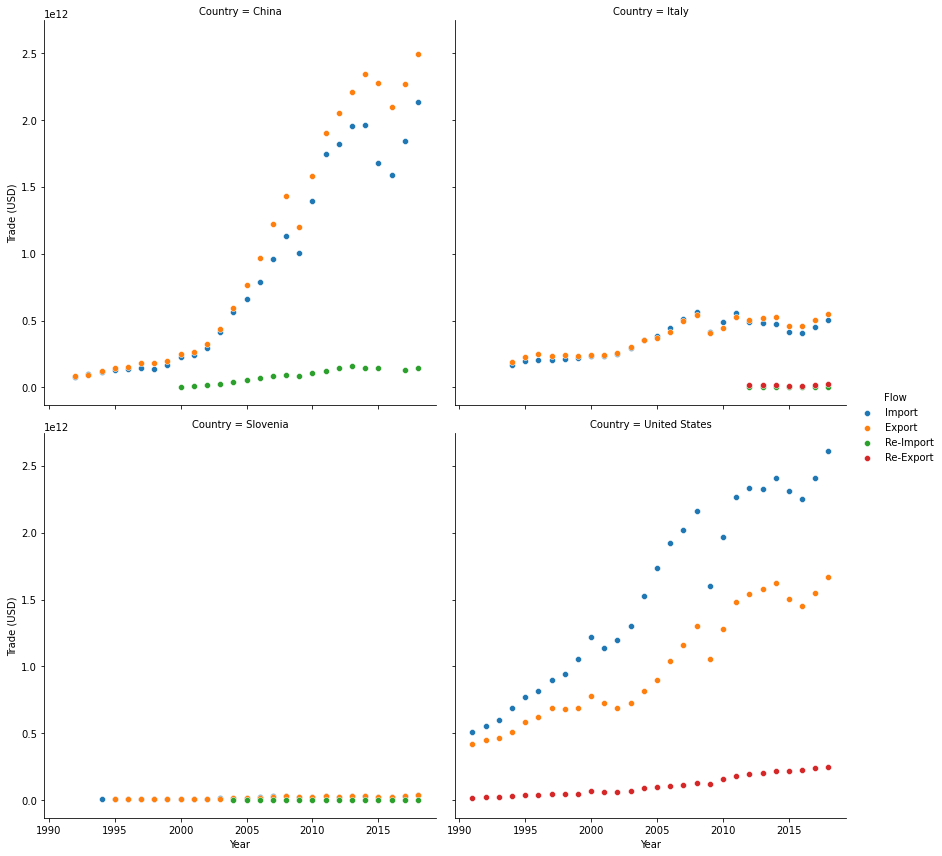

In [6]:
# I made plotting into a function!! Yay!
countries_plot(
    dataset=gdp_trade,
    country_list=['Slovenia', 'Italy', 'United States', 'China'],
    nplots_row = 2,
    plot_x = 'Year',
    plot_y = 'Trade (USD)',
    hue_var = 'Flow'
    )

Comment on above graphs: Slo's trade is ofc negligible compared to US. What's interesting though is that Italy seems to be oscillating around the same value, while the US is consistently on the rise, though the imports are outpacing the exports. China instead is exporting more than importing.

Idea: look at top 10 countries with highest GDP and check different statistics for them

In [7]:
(gdp_df
    .loc[gdp_df['Year'] == gdp_df['Year'].max()]
    .sort_values('GDP_Per_Capita', ascending=False)
    .head(11)
)

,Country,Year,GDP_Per_Capita
3716,"Macao SAR, China",2019,123965.286432
3686,Luxembourg,2019,114304.044210
5459,Singapore,2019,97341.468645
5133,Qatar,2019,90043.926180
2890,Ireland,2019,86826.335102
556,Bermuda,2019,81658.613276
6034,Switzerland,2019,68390.712985
6512,United Arab Emirates,2019,67119.132637
4643,Norway,2019,64962.262266
6572,United States,2019,62530.389595


I selected top 11 countries for the last year available (2019) sorted from highest GDP_Per_Capita to lowest. The reason I did top 11 is because Macao SAR, China is technically a self-governing(*ish) City, so I haven't decided if I'm going to include it or exclude for further comparisons. Below the top 10 for comparison.

In [8]:
(gdp_df
    .loc[gdp_df['Year'] == gdp_df['Year'].max()]
    .sort_values('GDP_Per_Capita', ascending=False)
    .tail(10)
)

,Country,Year,GDP_Per_Capita
3746,Madagascar,2019,1647.021160
6234,Togo,2019,1596.644938
1102,Chad,2019,1579.626695
3530,Liberia,2019,1427.819090
4297,Mozambique,2019,1281.391836
4523,Niger,2019,1224.510472
1417,Dem. Rep. Congo,2019,1097.948853
3776,Malawi,2019,1059.723490
1042,Central African Republic,2019,944.868093
822,Burundi,2019,751.663957


In [9]:
top10_gdp = (gdp_df
    .loc[
        (gdp_df['Year'] == gdp_df['Year'].max()) &
        (gdp_df['Country'] != 'Macao SAR, China')
        ]
    .sort_values('GDP_Per_Capita', ascending=False)
    .head(10)['Country']
)

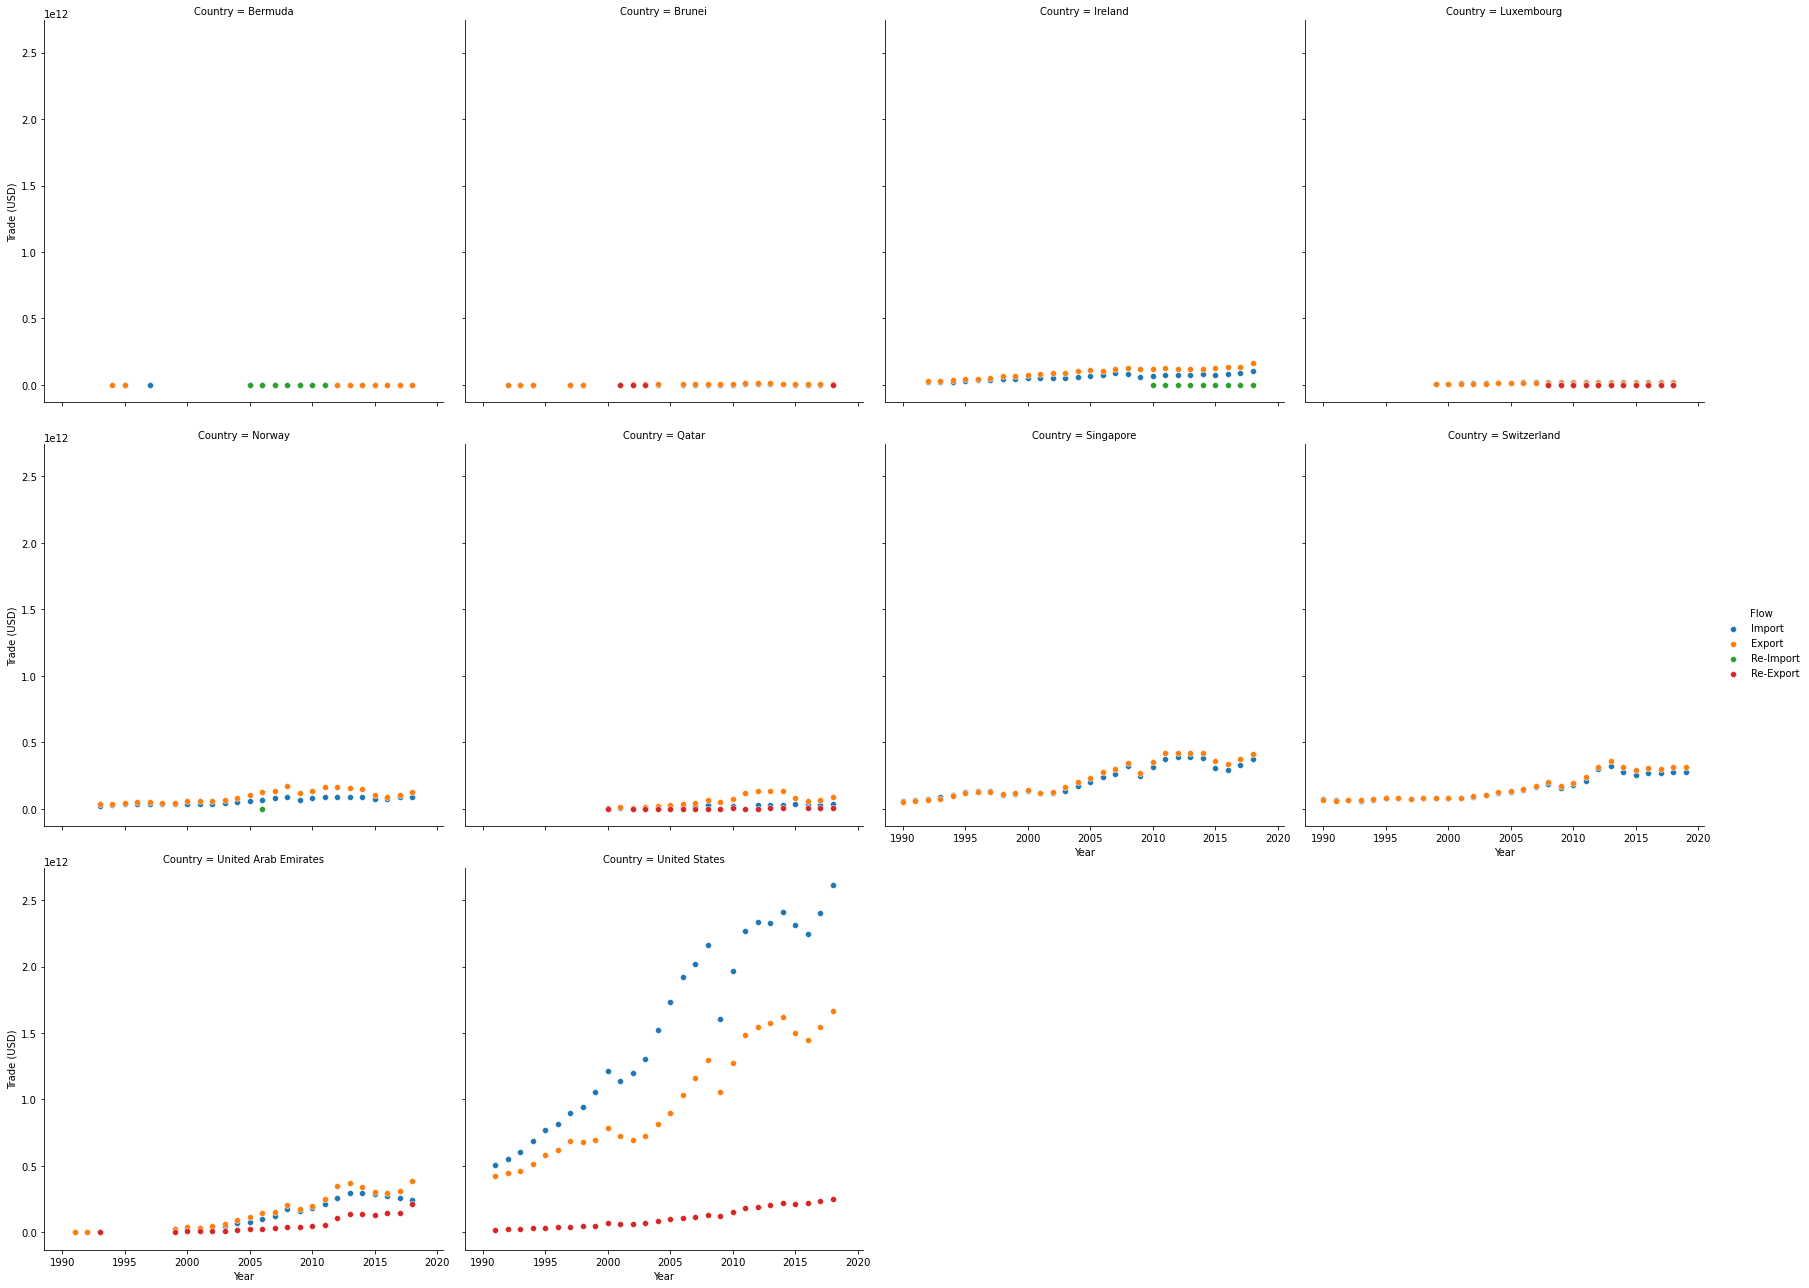

In [10]:
# g2 = sns.FacetGrid(
#     gdp_trade.loc[gdp_trade['Country'].isin(top10_gdp)],
#    col='Country',
#    col_wrap=4,
#    hue='Flow',
#    height=6
#)
#g2.map(sns.scatterplot, 'Year', 'Trade (USD)')
#g2.add_legend()

countries_plot(
    dataset=gdp_trade,
    country_list=top10_gdp,
    nplots_row = 4,
    plot_x = 'Year',
    plot_y = 'Trade (USD)',
    hue_var = 'Flow'
    )

Interestingly enough, the other 9 top countries per GDP per capita can't compare to the UDS trade. I'll have to normalize the trade values per capita.

In [11]:
population = pd.read_csv('../data/Population1990to2019.csv')

This data has already been filtered from 1990 to 2019, because the database was too big to download. Furthermore, this data includes predictors for future years; for past years it's all the same, so I decided to keep only the 'no change' (although it doesn't matter)

In [12]:
population = (
    population
        .loc[population['Variant'] == 'No change']
        .drop(columns='Variant')
        .rename(columns={'Country or Area' : 'Country', 'Year(s)' : 'Year', 'Value' : 'Population'})
)

population['Country'] = (
    population['Country']
        .str.replace('United States of America', 'United States')
        .str.replace('Brunei Darussalam', 'Brunei')
        .str.replace(r'Bolivia.+', 'Bolivia', regex=True)
)

In [13]:
#did not realize this at first, the population was in thousands; need to multiply!
population['Population'] = population['Population'] * 1000

In [14]:
gdp_trade_pop = pd.merge(gdp_trade, population, "inner", on=['Country', 'Year'])

Adjusting the trade to trade per capita (dividing Trade (USD) by Population)

In [15]:
gdp_trade_pop['Trade_Per_Capita'] = gdp_trade_pop['Trade (USD)'] / gdp_trade_pop['Population'] 

In [16]:
gdp_trade_pop.head()

,Country,Year,GDP_Per_Capita,Flow,Trade (USD),Population,Trade_Per_Capita
0,Afghanistan,2018,2033.779002,Import,7.406590e+09,37171921.0,199.252288
1,Afghanistan,2018,2033.779002,Export,8.845045e+08,37171921.0,23.794963
2,Afghanistan,2018,2033.779002,Re-Export,9.263097e+06,37171921.0,0.249196
3,Afghanistan,2016,2057.062164,Import,6.534140e+09,35383032.0,184.668753
4,Afghanistan,2016,2057.062164,Export,5.964553e+08,35383032.0,16.857101


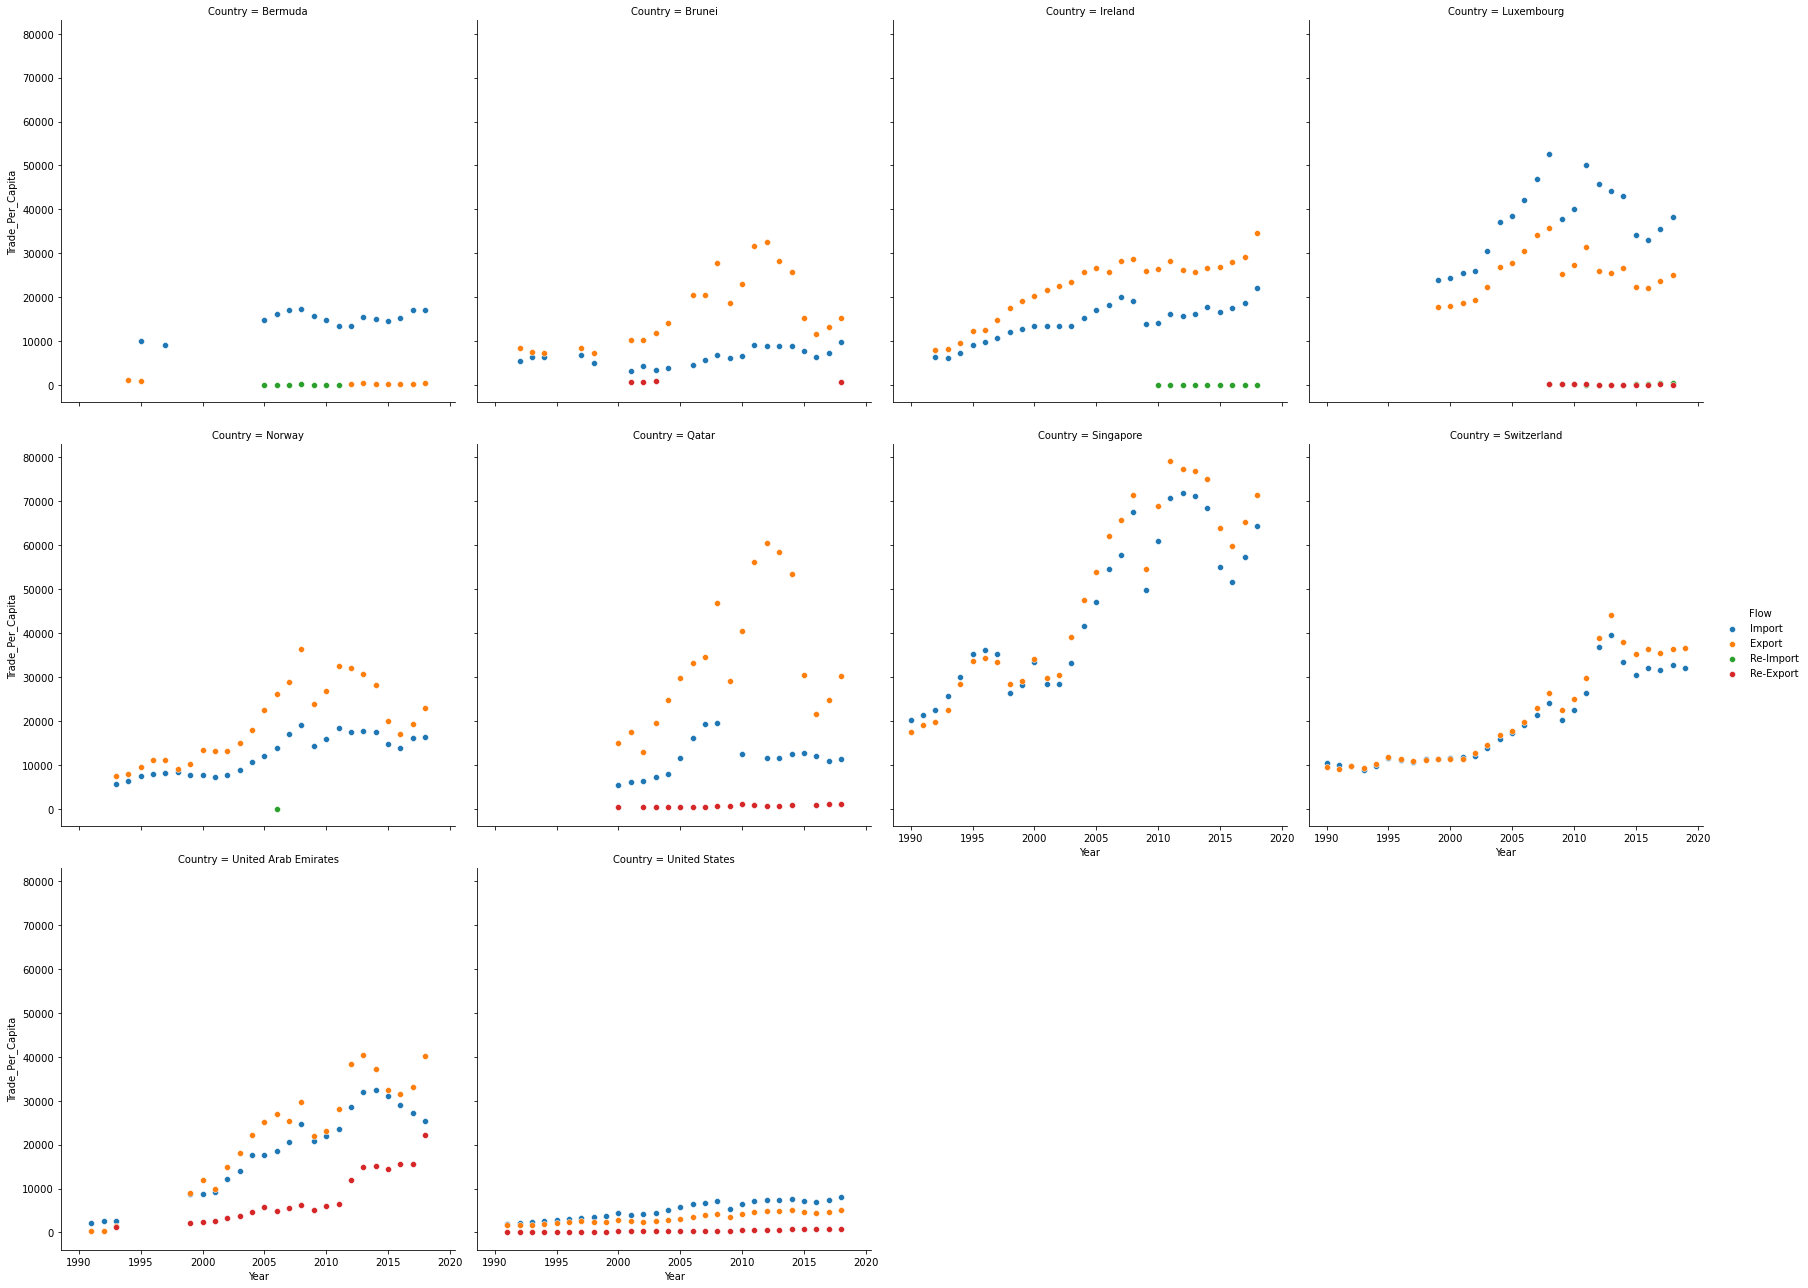

In [17]:
#g3 = sns.FacetGrid(
#    gdp_trade_pop.loc[gdp_trade_pop['Country'].isin(top10_gdp)],
#    col='Country',
#    col_wrap=4,
#    hue='Flow',
#    height=6
#)
#g3.map(sns.scatterplot, 'Year', 'Trade_Per_Capita')
#g3.add_legend()

countries_plot(
    dataset=gdp_trade_pop,
    country_list=top10_gdp,
    nplots_row = 4,
    plot_x = 'Year',
    plot_y = 'Trade_Per_Capita',
    hue_var = 'Flow'
    )


I had to go back and fix the USA / United States / United States of America, as well as Brunei Darussalam to Brunei

When adjusted for population, the graphs of trade paint quite a different picture. In terms of exporting goods, Singapore, Switzerland and Arab Emirates are outstanding. Also Ireland - that's the one I'm most surprised about in all honesty.

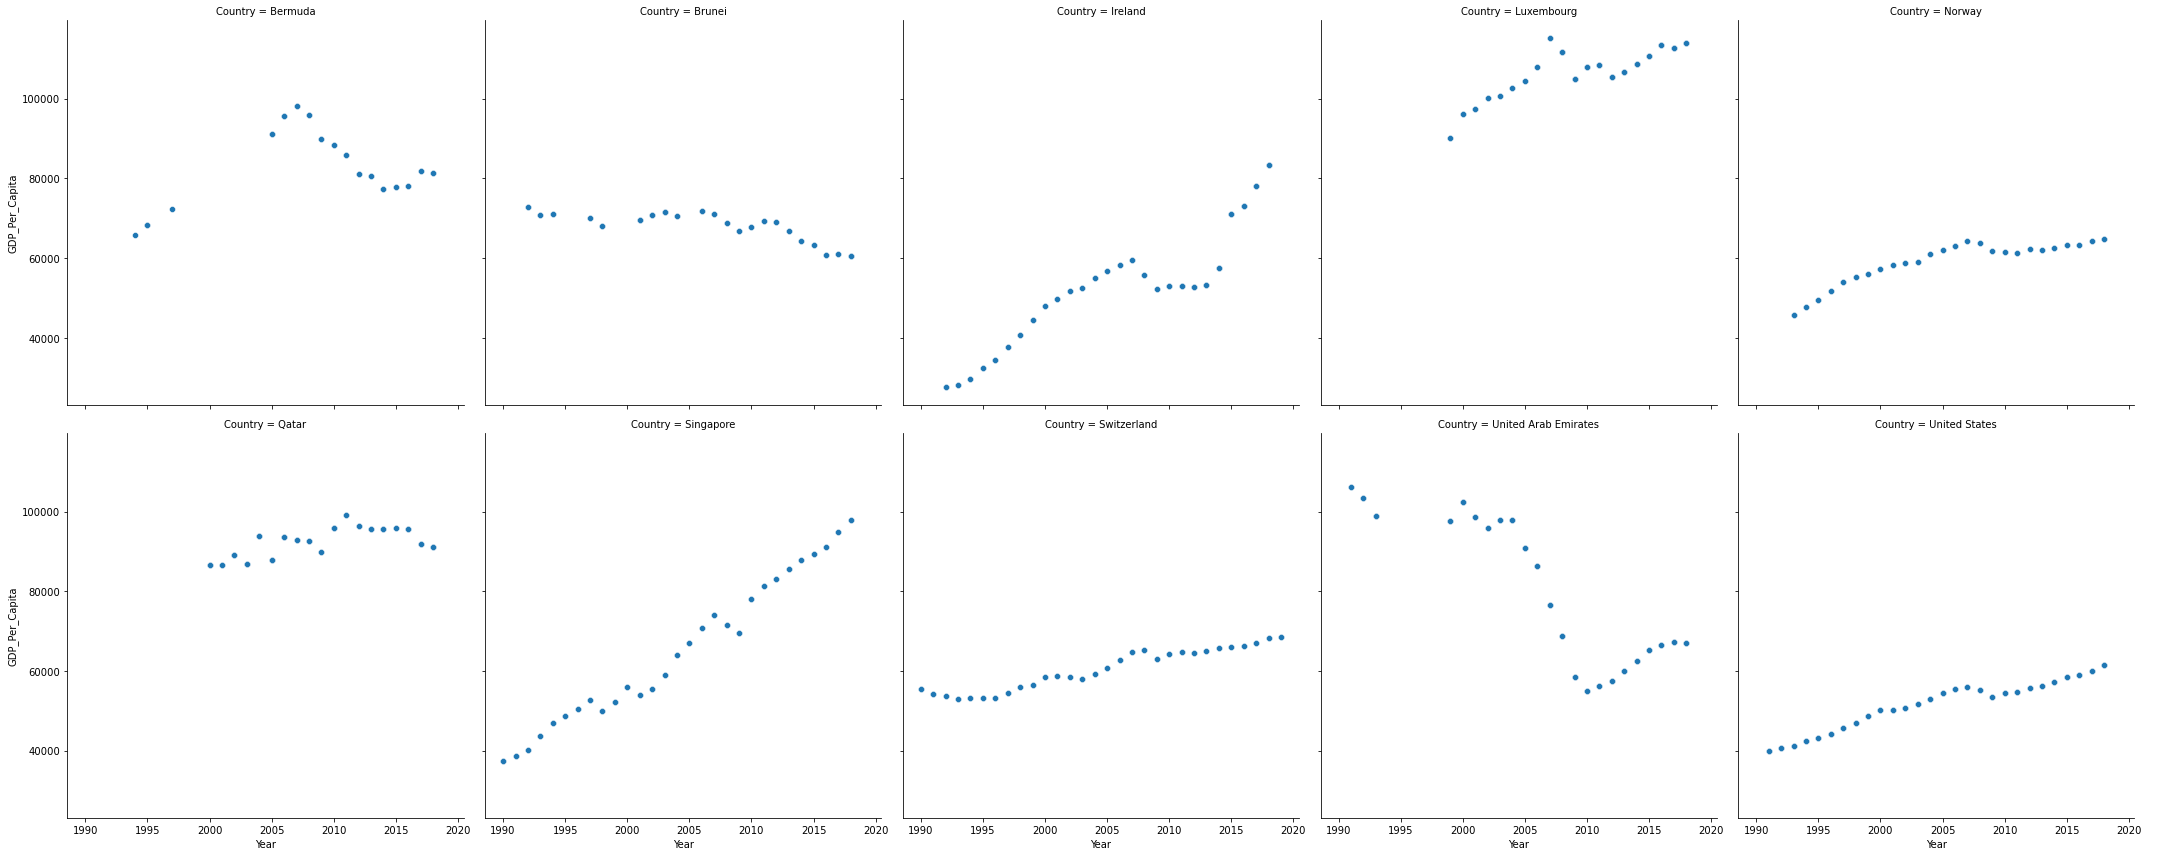

In [18]:
#g4 = sns.FacetGrid(
#    gdp_trade_pop.loc[gdp_trade_pop['Country'].isin(top10_gdp)],
#    col='Country',
#    col_wrap=5
#)
#g4.map(sns.scatterplot, 'Year', 'GDP_Per_Capita')
#g4.add_legend()

countries_plot(
    dataset=gdp_trade_pop,
    country_list=top10_gdp,
    nplots_row = 5,
    plot_x = 'Year',
    plot_y = 'GDP_Per_Capita',
    )

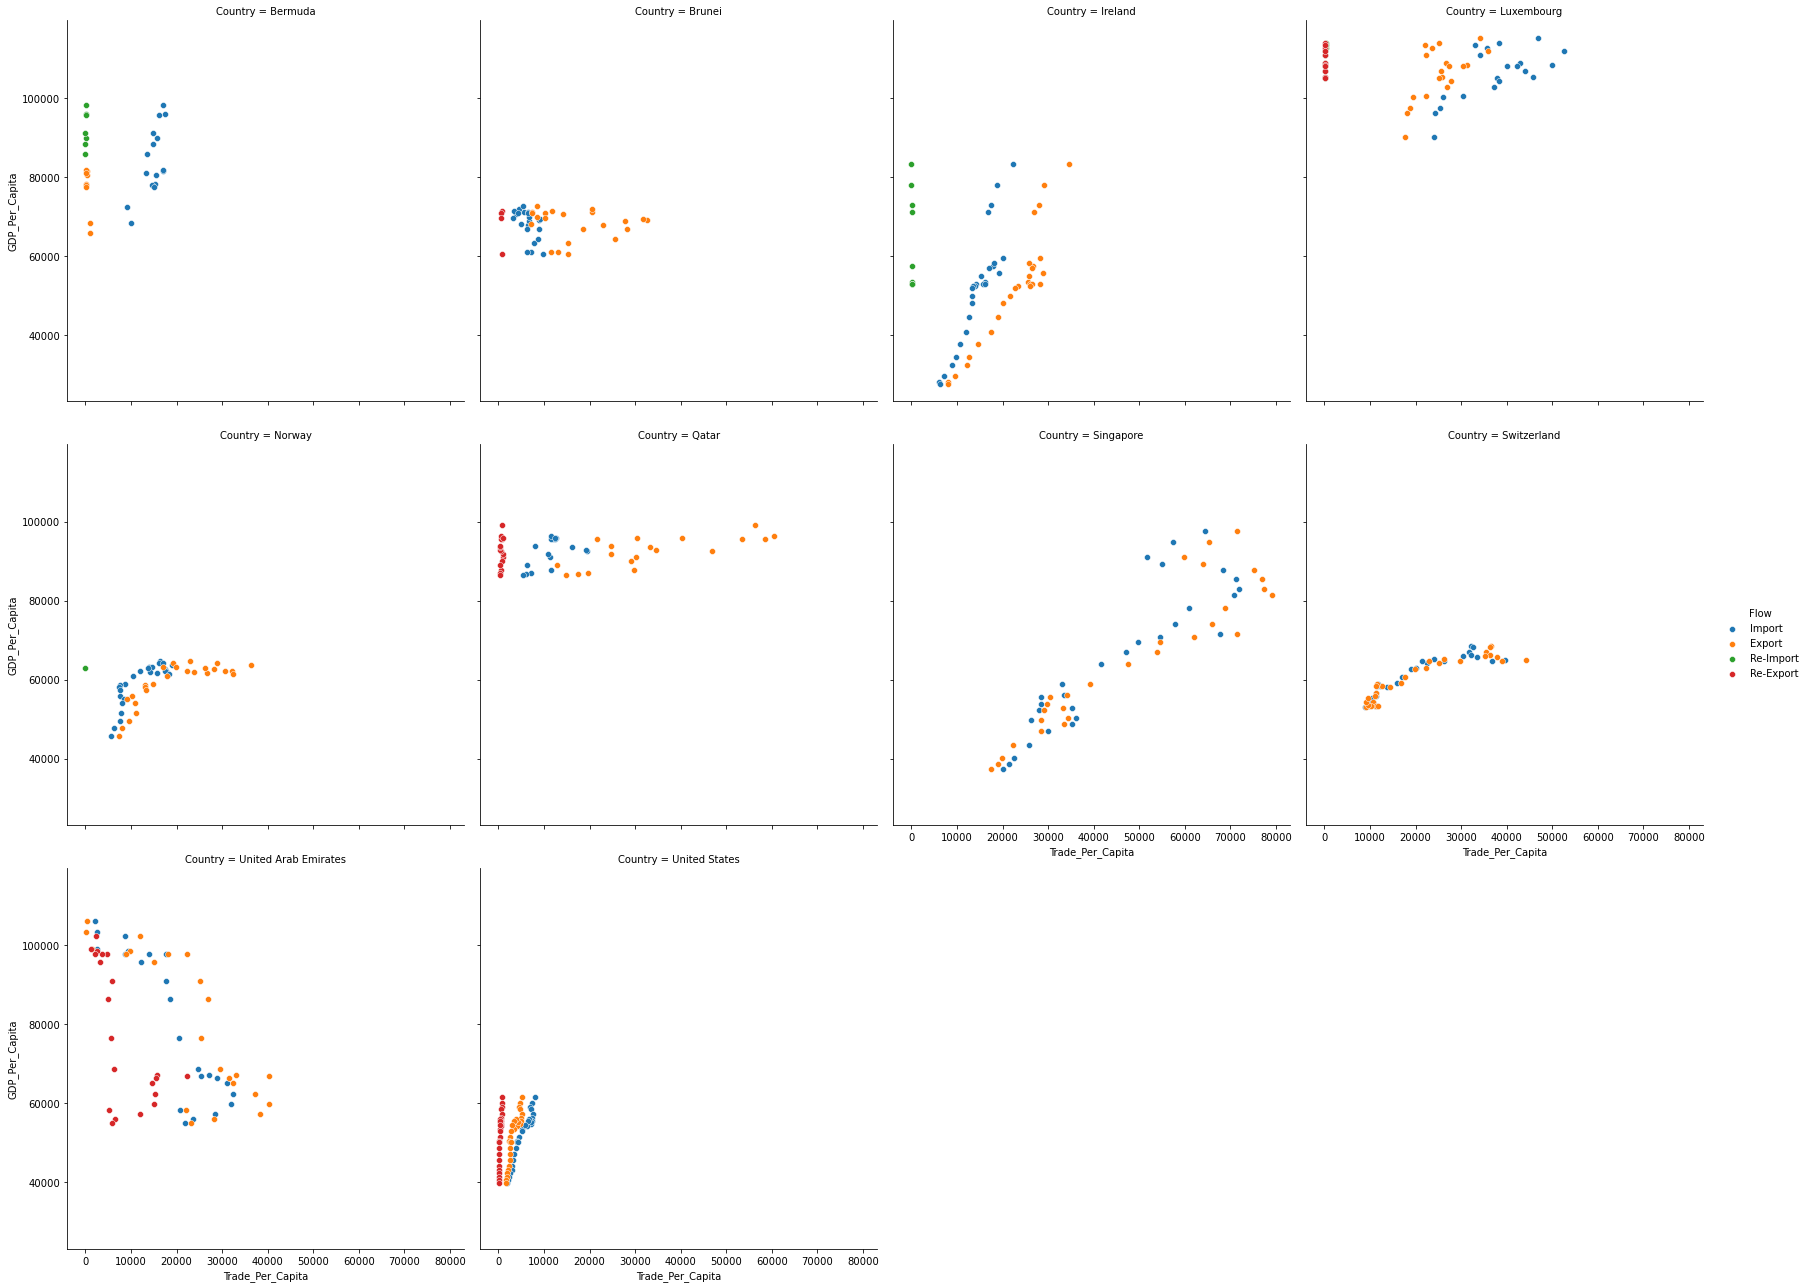

In [19]:
#g5 = sns.FacetGrid(
#    gdp_trade_pop.loc[gdp_trade_pop['Country'].isin(top10_gdp)],
#    col='Country',
#    col_wrap=4,
#    hue='Flow',
#    height=5
#)
#g5.map(sns.scatterplot, 'Trade_Per_Capita', 'GDP_Per_Capita')
#g5.add_legend()

countries_plot(
    dataset=gdp_trade_pop,
    country_list=top10_gdp,
    nplots_row = 4,
    plot_x = 'Trade_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    hue_var = 'Flow'
    )

Above is the plot I was initially curious to see. comparing hte GDP Per capita to the Trade Per Capita. I was wondering what impact does the trade have on GDP. Without any research I'd imagine that if we're looking just at Import/Export, the more the difference between those two would be, the higher the GDP. Interestingly, I don't see such a clear trend for most countries.

In [20]:
gdp_trade_pop.head()

,Country,Year,GDP_Per_Capita,Flow,Trade (USD),Population,Trade_Per_Capita
0,Afghanistan,2018,2033.779002,Import,7.406590e+09,37171921.0,199.252288
1,Afghanistan,2018,2033.779002,Export,8.845045e+08,37171921.0,23.794963
2,Afghanistan,2018,2033.779002,Re-Export,9.263097e+06,37171921.0,0.249196
3,Afghanistan,2016,2057.062164,Import,6.534140e+09,35383032.0,184.668753
4,Afghanistan,2016,2057.062164,Export,5.964553e+08,35383032.0,16.857101


In [21]:
# don't do for loops in pandas ... if you do, typically means you did something wrong
# if (row['Flow'] == 'Import') or (row['Flow'] == 'Re-Import'):
#    gdp_trade_pop.loc[index, 'Trade (USD)'] = gdp_trade_pop.loc[index, 'Trade (USD)'] * (-1)
#    gdp_trade_pop.loc[index, 'Trade_Per_Capita'] = gdp_trade_pop.loc[index, 'Trade_Per_Capita'] * (-1)

In [22]:
# same as pivot below
# gdp_trade_pop.pivot_table(index=['Country', 'Year', 'GDP_Per_Capita', 'Population'], columns=['Flow']).reset_index()

In [23]:
# this below would work, except I'd need to find a way to get rid of the sub-columns
gdp_trade_pop.pivot(index=['Country', 'Year', 'GDP_Per_Capita', 'Population'], columns='Flow').reset_index()

Country  Year GDP_Per_Capita  Population   Trade (USD)  \
Flow                                                      Export   
0     Afghanistan  2008    1484.114729  27722276.0  5.400656e+08   
1     Afghanistan  2009    1758.904043  28394813.0  4.034410e+08   
2     Afghanistan  2010    1957.029338  29185507.0  3.884836e+08   
3     Afghanistan  2011    1904.559799  30117413.0  3.758509e+08   
4     Afghanistan  2012    2075.491747  31161376.0  4.289027e+08   
...           ...   ...            ...         ...           ...   
3277     Zimbabwe  2014    2955.240287  13586707.0  3.063741e+09   
3278     Zimbabwe  2015    2958.209004  13814629.0  2.704096e+09   
3279     Zimbabwe  2016    2934.733650  14030331.0  2.832310e+09   
3280     Zimbabwe  2017    3028.245976  14236595.0  3.480382e+09   
3281     Zimbabwe  2018    3130.029501  14438802.0  4.037203e+09   

                                       Trade_Per_Capita                        \
Flow        Import Re-Export Re-Import           Export      Import Re-Export   
0     3.019860e+09       NaN       NaN        19.481286  108.932619       NaN   
1     3.336435e+09       NaN       NaN        14.208264  117.501559       NaN   
2     5.154250e+09       NaN       NaN        13.310841  176.603061       NaN   
3     6.390311e+09       NaN       NaN        12.479523  212.179942       NaN   
4     6.204984e+09       NaN       NaN        13.763921  199.124201       NaN   
...            ...       ...       ...              ...         ...       ...   
3277  6.379758e+09       NaN       NaN       225.495505  469.558815       NaN   
3278  6.002232e+09       NaN       NaN       195.741482  434.483753       NaN   
3279  5.211577e+09       NaN       NaN       201.870505  371.450727       NaN   
3280  4.962103e+09       NaN       NaN       244.467295  348.545612       NaN   
3281  6.258856e+09       NaN       NaN       279.607870  433.474757       NaN   

                
Flow Re-Import  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
3277       NaN  
3278       NaN  
3279       NaN  
3280       NaN  
3281       NaN  

[3282 rows x 12 columns]

In [24]:
# the function below is made in order to separate the Trade(USD);
# only downside is that with this method, Trade_Per_Capita could not be kept so I'll need to calculate it again
gdp_trade_pop = (
    gdp_trade_pop
        .pivot(
            index=['Country', 'Year', 'GDP_Per_Capita', 'Population'],
            columns='Flow',
            values='Trade (USD)')
        .reset_index()
        .rename_axis(None, axis=1)
        .fillna(0)
)

In [25]:
gdp_trade_pop['Surplus_Deficit'] = gdp_trade_pop['Export'] + gdp_trade_pop['Re-Export'] - gdp_trade_pop['Import'] - gdp_trade_pop['Re-Import']
gdp_trade_pop['Export_Per_Capita'] = gdp_trade_pop['Export'] / gdp_trade_pop['Population'] 
gdp_trade_pop['Import_Per_Capita'] = gdp_trade_pop['Import'] / gdp_trade_pop['Population'] 
gdp_trade_pop['Re-Export_Per_Capita'] = gdp_trade_pop['Re-Export'] / gdp_trade_pop['Population'] 
gdp_trade_pop['Re-Import_Per_Capita'] = gdp_trade_pop['Re-Import'] / gdp_trade_pop['Population']
gdp_trade_pop['Surplus_Deficit_Per_Capita'] = gdp_trade_pop['Surplus_Deficit'] / gdp_trade_pop['Population']

Now that I have this, let's look at some countries (irrespective of year) who had the biggest surplus, or deficit based on their exports and imports.

I'm surprised that for many years Luxembourg appears amongst the worst!

In [26]:
gdp_trade_pop.sort_values(by='Surplus_Deficit_Per_Capita').head(10)

,Country,Year,GDP_Per_Capita,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
1799,Luxembourg,2012,105411.464571,530857.0,1.372690e+10,2.428489e+10,52512186.0,51715604.0,-1.055719e+10,25858.004466,45746.575743,98.919645,97.419086,-19887.070718
1800,Luxembourg,2013,106767.275005,542560.0,1.382601e+10,2.393408e+10,51926788.0,49761896.0,-1.010591e+10,25482.906934,44113.241249,95.706996,91.716853,-18626.344172
1798,Luxembourg,2011,108355.582583,519307.0,1.630788e+10,2.597163e+10,70066127.0,47333435.0,-9.641022e+09,31403.157306,50012.100557,134.922362,91.147308,-18565.168197
389,Bermuda,2008,95855.800693,65931.0,0.000000e+00,1.146778e+09,0.0,11815701.0,-1.158594e+09,0.000000,17393.607195,0.000000,179.213132,-17572.820327
388,Bermuda,2007,98257.992698,66129.0,0.000000e+00,1.133147e+09,0.0,4202056.0,-1.137349e+09,0.000000,17135.403333,0.000000,63.543317,-17198.946650
398,Bermuda,2017,81834.955874,63049.0,1.174217e+07,1.078214e+09,0.0,0.0,-1.066472e+09,186.238730,17101.203583,0.000000,0.000000,-16914.964854
1795,Luxembourg,2008,111765.450698,485405.0,1.738080e+10,2.549810e+10,73531997.0,67815510.0,-8.111582e+09,35806.793741,52529.527650,151.485866,139.709129,-16710.957172
399,Bermuda,2018,81420.860787,62756.0,2.291242e+07,1.070009e+09,0.0,0.0,-1.047097e+09,365.103329,17050.306185,0.000000,0.000000,-16685.202855
1801,Luxembourg,2014,108760.916030,554516.0,1.479088e+10,2.385001e+10,44561207.0,50934806.0,-9.065503e+09,26673.500775,43010.503482,80.360543,91.854529,-16348.496693
387,Bermuda,2006,95615.360697,66248.0,0.000000e+00,1.070974e+09,0.0,4915428.0,-1.075889e+09,0.000000,16166.131445,0.000000,74.197380,-16240.328825


In [27]:
gdp_trade_pop.sort_values(by='Surplus_Deficit_Per_Capita').tail(10)

,Country,Year,GDP_Per_Capita,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
1688,Kuwait,2008,73022.863351,2656009.0,8.745702e+10,2.483959e+10,1.716346e+09,0.0,6.433378e+10,32927.984191,9352.223973,646.212265,0.0,24221.972484
1691,Kuwait,2011,60887.459367,3168060.0,1.026958e+11,2.514199e+10,0.000000e+00,0.0,7.755377e+10,32415.977744,7936.084454,0.000000,0.0,24479.893290
2531,Qatar,2008,92555.622454,1436665.0,6.730714e+10,2.790004e+10,8.654572e+08,0.0,4.027256e+10,46849.573816,19420.004330,602.407122,0.0,28031.976608
2533,Qatar,2010,95908.416157,1856327.0,7.496442e+10,2.323955e+10,2.010391e+09,0.0,5.373526e+10,40383.195123,12519.101020,1082.993906,0.0,28947.088009
2532,Qatar,2009,89954.519993,1654950.0,4.800711e+10,0.000000e+00,1.167151e+09,0.0,4.917426e+10,29008.191906,0.000000,705.248443,0.0,29713.440349
3150,United Arab Emirates,2018,66968.269855,9630959.0,3.879100e+11,2.446459e+11,2.145678e+11,0.0,3.578319e+11,40277.405455,25402.027992,22278.960050,0.0,37154.337512
2537,Qatar,2014,95578.416973,2459198.0,1.315916e+11,3.044766e+10,1.893152e+09,0.0,1.030370e+11,53509.946461,12381.132365,769.824824,0.0,41898.638921
2536,Qatar,2013,95500.111972,2336574.0,1.368551e+11,2.703410e+10,1.585849e+09,0.0,1.114069e+11,58570.846080,11569.975093,678.706806,0.0,47679.577794
2535,Qatar,2012,96261.662668,2196073.0,1.329848e+11,2.520495e+10,1.370611e+09,0.0,1.091505e+11,60555.723082,11477.281027,624.119073,0.0,49702.561128
2534,Qatar,2011,99146.849879,2035871.0,1.144481e+11,0.000000e+00,1.535927e+09,0.0,1.159841e+11,56215.807358,0.000000,754.432598,0.0,56970.239956


Just checking now the same, but only for the year 2019

In [28]:
gdp_trade_pop.loc[gdp_trade_pop['Year'] == gdp_trade_pop['Year'].max()].sort_values(by='Surplus_Deficit_Per_Capita').head(10)


,Country,Year,GDP_Per_Capita,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
1230,Greece,2019,30463.041048,10473455.0,3.780546e+10,6.210039e+10,0.000000e+00,0.000000e+00,-2.429493e+10,3609.645863,5929.312730,0.000000,0.000000,-2319.666867
1152,Georgia,2019,14993.120442,3996765.0,3.771399e+09,9.063244e+09,1.419164e+09,8.127176e+06,-3.880808e+09,943.612913,2267.644938,355.078292,2.033439,-970.987172
994,El Salvador,2019,8775.986520,6453553.0,5.943316e+09,1.201756e+10,0.000000e+00,1.241036e+07,-6.086653e+09,920.937114,1862.161718,0.000000,1.923028,-943.147633
132,Armenia,2019,13653.749532,2957731.0,2.611701e+09,5.053062e+09,2.140861e+08,5.859051e+05,-2.227861e+09,883.008194,1708.425240,72.381861,0.198093,-753.233278
2659,Senegal,2019,3394.868808,16296364.0,4.174502e+09,8.143113e+09,0.000000e+00,0.000000e+00,-3.968611e+09,256.161567,499.688978,0.000000,0.000000,-243.527411
1596,Japan,2019,41667.179096,126860301.0,7.056400e+11,7.208948e+11,0.000000e+00,0.000000e+00,-1.525482e+10,5562.338610,5682.587611,0.000000,0.000000,-120.249001
703,Chile,2019,25131.464758,18952038.0,6.968140e+10,6.959130e+10,0.000000e+00,1.643104e+07,7.366793e+07,3676.723149,3671.969097,0.000000,0.866980,3.887072
2493,Poland,2019,33226.265918,37887768.0,2.518648e+11,2.466539e+11,0.000000e+00,0.000000e+00,5.210893e+09,6647.654020,6510.119050,0.000000,0.000000,137.534970
228,Azerbaijan,2019,14402.463864,10047718.0,1.963558e+10,1.364927e+10,0.000000e+00,0.000000e+00,5.986312e+09,1954.232817,1358.444632,0.000000,0.000000,595.788185
672,Canada,2019,48881.396751,37411047.0,4.457275e+11,4.530126e+11,3.627237e+10,3.356662e+09,2.563056e+10,11914.327763,12109.060532,969.563180,89.723811,685.106600


In [29]:
gdp_trade_pop.loc[gdp_trade_pop['Year'] == gdp_trade_pop['Year'].max()].sort_values(by='Surplus_Deficit_Per_Capita').tail(10)


,Country,Year,GDP_Per_Capita,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
994,El Salvador,2019,8775.986520,6453553.0,5.943316e+09,1.201756e+10,0.000000e+00,1.241036e+07,-6.086653e+09,920.937114,1862.161718,0.000000,1.923028,-943.147633
132,Armenia,2019,13653.749532,2957731.0,2.611701e+09,5.053062e+09,2.140861e+08,5.859051e+05,-2.227861e+09,883.008194,1708.425240,72.381861,0.198093,-753.233278
2659,Senegal,2019,3394.868808,16296364.0,4.174502e+09,8.143113e+09,0.000000e+00,0.000000e+00,-3.968611e+09,256.161567,499.688978,0.000000,0.000000,-243.527411
1596,Japan,2019,41667.179096,126860301.0,7.056400e+11,7.208948e+11,0.000000e+00,0.000000e+00,-1.525482e+10,5562.338610,5682.587611,0.000000,0.000000,-120.249001
703,Chile,2019,25131.464758,18952038.0,6.968140e+10,6.959130e+10,0.000000e+00,1.643104e+07,7.366793e+07,3676.723149,3671.969097,0.000000,0.866980,3.887072
2493,Poland,2019,33226.265918,37887768.0,2.518648e+11,2.466539e+11,0.000000e+00,0.000000e+00,5.210893e+09,6647.654020,6510.119050,0.000000,0.000000,137.534970
228,Azerbaijan,2019,14402.463864,10047718.0,1.963558e+10,1.364927e+10,0.000000e+00,0.000000e+00,5.986312e+09,1954.232817,1358.444632,0.000000,0.000000,595.788185
672,Canada,2019,48881.396751,37411047.0,4.457275e+11,4.530126e+11,3.627237e+10,3.356662e+09,2.563056e+10,11914.327763,12109.060532,969.563180,89.723811,685.106600
897,Denmark,2019,57862.278278,5771876.0,1.098668e+11,9.700914e+10,0.000000e+00,0.000000e+00,1.285767e+10,19034.852707,16807.212061,0.000000,0.000000,2227.640646
2912,Switzerland,2019,68390.712985,8591365.0,3.136296e+11,2.762918e+11,0.000000e+00,0.000000e+00,3.733774e+10,36505.206123,32159.244926,0.000000,0.000000,4345.961197


Luxemburg disappeared from bottom 10 in 2019, yay! With that said, of the top 10 GDP earners, only Switzerland appears to have the highest surplus! Also, alright Poland, those Witcher sales looking good for your economy, lol!

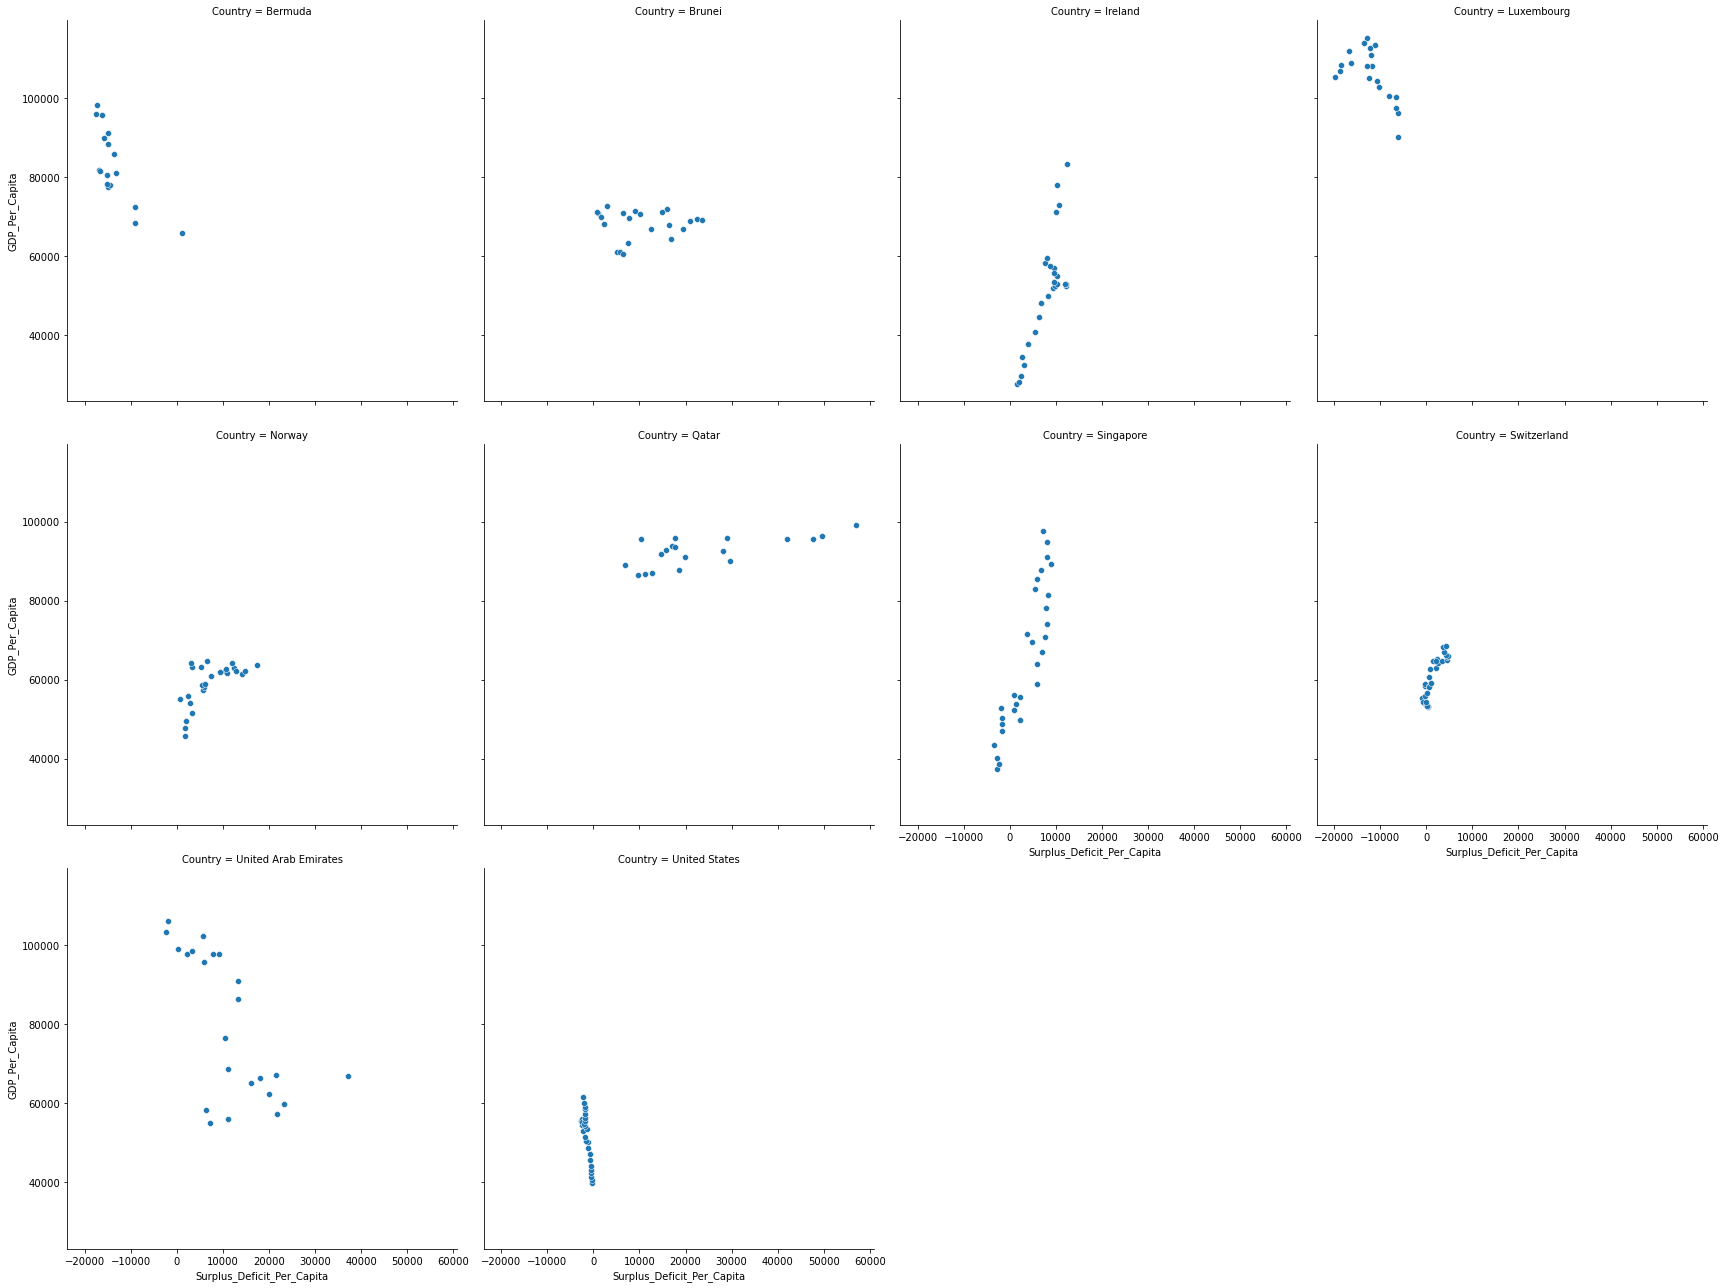

In [30]:
#g6 = sns.FacetGrid(
#    gdp_trade_pop.loc[gdp_trade_pop['Country'].isin(top10_gdp)],
#    col='Country',
#    col_wrap=4,
#    hue='Year',
#    height=6
#)
#g6.map(sns.scatterplot, 'Surplus_Deficit_Per_Capita', 'GDP_Per_Capita')
#g6.add_legend()

countries_plot(
    dataset=gdp_trade_pop,
    country_list=top10_gdp,
    nplots_row = 4,
    plot_x = 'Surplus_Deficit_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    )

A more clear look at what above - a higher surplus does not necessarily mean higher GDP.

Below just some plots for Slovenia, because why not?

> EDIT: idea for later, fix the function to be able to have single countries instead of a list

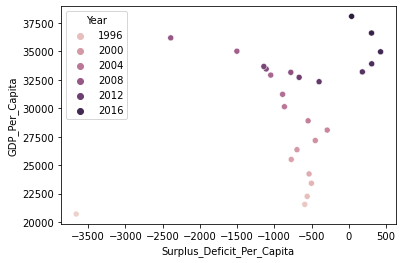

In [31]:
sns.scatterplot(
    data=gdp_trade_pop.loc[gdp_trade_pop['Country']=='Slovenia'],
    x='Surplus_Deficit_Per_Capita',
    y='GDP_Per_Capita',
    hue='Year'
);

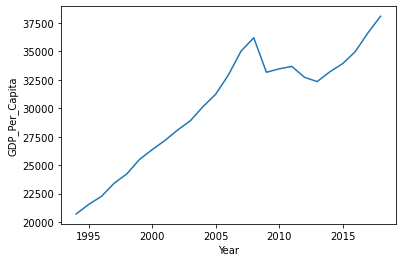

In [32]:
sns.lineplot(
    data=gdp_trade_pop.loc[gdp_trade_pop['Country']=='Slovenia'],
    x='Year',
    y='GDP_Per_Capita'
);


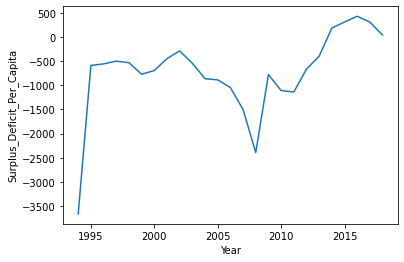

In [33]:
sns.lineplot(
    data=gdp_trade_pop.loc[gdp_trade_pop['Country']=='Slovenia'],
    x='Year',
    y='Surplus_Deficit_Per_Capita'
);

After all this: idea to compare the highest GDP and lowest GDP per different continents.

In [34]:
continents = pd.read_csv('../data/continents.csv')

In [35]:
gdp_trade_pop_continent = pd.merge(gdp_trade_pop, continents, how='inner', on='Country')

In [36]:
gdp_trade_pop_continent.value_counts('Continent')

Continent
Europe           925
Africa           780
Asia             692
North America    424
South America    295
Oceania          166
dtype: int64

First of all, create a list of top GDP countries per each continent and bottom GDP countries per each continent (6 in each list).

In [37]:
gdp_trade_pop_continent.groupby('Continent')['GDP_Per_Capita'].describe()

,count,mean,std,min,25%,50%,75%,max
Continent,,,,,,,,
Africa,780.0,5214.083354,5306.622205,469.189231,1570.981226,2905.320056,7362.106934,27996.770572
Asia,692.0,24671.956771,25300.683707,658.107935,5456.149131,14261.901478,37587.436352,106103.881293
Europe,925.0,33560.639472,19114.712673,3033.830388,18083.251996,32169.252380,45061.605638,115256.016699
North America,424.0,20283.317545,19064.490718,2401.826183,7262.422414,14005.467168,26703.580122,98257.992698
Oceania,166.0,17545.434791,15806.533386,1921.723959,3496.426975,10557.384701,33010.469874,49304.251113
South America,295.0,12417.838918,4997.879655,4705.585170,8627.528218,11520.331639,15194.097391,25165.178178


Comment: I knew that they were going to be skewed (with some countries having much higher gdp than others), but something doesn't look right!

In [38]:
gdp_trade_pop_continent.loc[gdp_trade_pop_continent['Year'] == gdp_trade_pop_continent['Year'].max()].groupby('Continent')['GDP_Per_Capita'].describe()

,count,mean,std,min,25%,50%,75%,max
Continent,,,,,,,,
Africa,1.0,3394.868808,NaN,3394.868808,3394.868808,3394.868808,3394.868808,3394.868808
Asia,1.0,41667.179096,NaN,41667.179096,41667.179096,41667.179096,41667.179096,41667.179096
Europe,7.0,33284.518867,22064.109680,13653.749532,14697.792153,30463.041048,45544.272098,68390.712985
North America,2.0,28828.691635,28358.807537,8775.986520,18802.339078,28828.691635,38855.044193,48881.396751
South America,1.0,25131.464758,NaN,25131.464758,25131.464758,25131.464758,25131.464758,25131.464758


In [39]:
gdp_trade_pop_continent.loc[gdp_trade_pop_continent['Year']==2019]

,Country,Year,GDP_Per_Capita,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita,Continent
132,Armenia,2019,13653.749532,2957731.0,2.611701e+09,5.053062e+09,2.140861e+08,5.859051e+05,-2.227861e+09,883.008194,1708.425240,72.381861,0.198093,-753.233278,Europe
228,Azerbaijan,2019,14402.463864,10047718.0,1.963558e+10,1.364927e+10,0.000000e+00,0.000000e+00,5.986312e+09,1954.232817,1358.444632,0.000000,0.000000,595.788185,Europe
672,Canada,2019,48881.396751,37411047.0,4.457275e+11,4.530126e+11,3.627237e+10,3.356662e+09,2.563056e+10,11914.327763,12109.060532,969.563180,89.723811,685.106600,North America
703,Chile,2019,25131.464758,18952038.0,6.968140e+10,6.959130e+10,0.000000e+00,1.643104e+07,7.366793e+07,3676.723149,3671.969097,0.000000,0.866980,3.887072,South America
897,Denmark,2019,57862.278278,5771876.0,1.098668e+11,9.700914e+10,0.000000e+00,0.000000e+00,1.285767e+10,19034.852707,16807.212061,0.000000,0.000000,2227.640646,Europe
994,El Salvador,2019,8775.986520,6453553.0,5.943316e+09,1.201756e+10,0.000000e+00,1.241036e+07,-6.086653e+09,920.937114,1862.161718,0.000000,1.923028,-943.147633,North America
1152,Georgia,2019,14993.120442,3996765.0,3.771399e+09,9.063244e+09,1.419164e+09,8.127176e+06,-3.880808e+09,943.612913,2267.644938,355.078292,2.033439,-970.987172,Europe
1230,Greece,2019,30463.041048,10473455.0,3.780546e+10,6.210039e+10,0.000000e+00,0.000000e+00,-2.429493e+10,3609.645863,5929.312730,0.000000,0.000000,-2319.666867,Europe
1596,Japan,2019,41667.179096,126860301.0,7.056400e+11,7.208948e+11,0.000000e+00,0.000000e+00,-1.525482e+10,5562.338610,5682.587611,0.000000,0.000000,-120.249001,Asia
2493,Poland,2019,33226.265918,37887768.0,2.518648e+11,2.466539e+11,0.000000e+00,0.000000e+00,5.210893e+09,6647.654020,6510.119050,0.000000,0.000000,137.534970,Europe


### After all this, just realized that GDP might not have all the values I need for year 2019 because of various INNER merges!

Ok, back to the original gdp_df file, to merge it with continents and see what's up.

In [40]:
gdp_continent = pd.merge(gdp_df, continents, how='inner', on='Country')

In [41]:
gdp_continent.loc[gdp_continent['Year'] == 2019].groupby('Continent')['GDP_Per_Capita'].describe()

,count,mean,std,min,25%,50%,75%,max
Continent,,,,,,,,
Africa,49.0,6024.606829,6249.898985,751.663957,2178.323415,3394.868808,7514.720881,29223.465013
Asia,42.0,26420.193529,28453.195727,2065.036398,6774.738563,12733.659850,41300.456177,123965.286432
Europe,44.0,37939.067887,21101.689840,11401.870686,21014.343131,35926.195949,49559.852689,114304.044210
North America,24.0,22912.340791,19076.001620,2905.439081,9515.120522,17725.896368,27693.307188,81658.613276
Oceania,12.0,13769.398493,16013.952915,2271.913438,3999.300135,6452.366127,14658.158622,49609.044033
South America,11.0,15752.085027,5080.806136,8724.475702,12766.499304,14624.971297,19042.910078,25131.464758


In [ ]:
gdp_continent.nlargest

In [101]:
max_gdp2019 = (
    gdp_continent
        .loc[(gdp_continent['Year'] == 2019) & (gdp_continent['Country'] != 'Macao SAR, China')]
        .groupby('Continent')['GDP_Per_Capita']
        .max()
)
max_gdp2019_countries = gdp_continent.loc[gdp_continent['GDP_Per_Capita'].isin(max_gdp2019)]['Country']

In [67]:
gdp_continent.loc[(gdp_continent['Year'] == 2019) & (gdp_continent['Country'] != 'Macao SAR, China')].groupby('Continent')['GDP_Per_Capita'].max()

Continent
Africa            29223.465013
Asia              97341.468645
Europe           114304.044210
North America     81658.613276
Oceania           49609.044033
South America     25131.464758
Name: GDP_Per_Capita, dtype: float64

In [43]:
max_gdp2019_countries

226      Australia
526        Bermuda
1012         Chile
2826    Luxembourg
4230    Seychelles
4290     Singapore
Name: Country, dtype: object

After checking for countries in the Trade dataset, I realized that most of these don't have a value for 2019 (last one is 2018). And Macao SAR, China is weird, stops at 2016, so excluding that one anyways!

After I ridid the same exact as above, except 2018, the same top 6 countries appeared!

can check the years with something like this trade.loc[trade['Country'] == 'Ukraine'].sort_values('Year', ascending=False)

Haiti only has values until 1997..., Honduraas 2017. For year 2019 Nicaragua has lower gdp than Honduras, and it does go until 2018, so I went with that. Also had to remove Kosovo as it's not in the Trade dataset!

In [44]:
min_gdp2019 = (
    gdp_continent
        .loc[(gdp_continent['Year'] == 2019) & (gdp_continent['Country'] != 'Haiti') & (gdp_continent['Country'] != 'Kosovo')]
        .groupby('Continent')['GDP_Per_Capita']
        .min()
)
min_gdp2019_countries = gdp_continent.loc[gdp_continent['GDP_Per_Capita'].isin(min_gdp2019)]['Country']

In [45]:
min_gdp2019_countries

0       Afghanistan
586         Bolivia
792         Burundi
2510       Kiribati
3513      Nicaragua
5117        Ukraine
Name: Country, dtype: object

In [46]:
minmax_gdp2019_countries = pd.concat([min_gdp2019_countries, max_gdp2019_countries])

In [47]:
minmax_gdp2019_countries

0       Afghanistan
586         Bolivia
792         Burundi
2510       Kiribati
3513      Nicaragua
5117        Ukraine
226       Australia
526         Bermuda
1012          Chile
2826     Luxembourg
4230     Seychelles
4290      Singapore
Name: Country, dtype: object

In [48]:
# by using code below, I found out which country was missing and it was Bolivia!
population.loc[population['Country'].isin(minmax_gdp2019_countries)].value_counts('Country')

Country
Afghanistan    30
Australia      30
Bermuda        30
Bolivia        30
Burundi        30
Chile          30
Kiribati       30
Luxembourg     30
Nicaragua      30
Seychelles     30
Singapore      30
Ukraine        30
dtype: int64

Now that I have the list, with the next command, filter the database on those 12 countries.

In [49]:
filtered_gdp_cont = gdp_continent.loc[gdp_continent['Country'].isin(minmax_gdp2019_countries)]

In [50]:
filtered_gdp_cont_pop = pd.merge(filtered_gdp_cont, population, "inner", on=['Country', 'Year'])

In [51]:
filtered_gdp_cont_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 347
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         348 non-null    object 
 1   Year            348 non-null    int64  
 2   GDP_Per_Capita  348 non-null    float64
 3   Continent       348 non-null    object 
 4   Population      348 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 16.3+ KB


In [52]:
trade_pivoted = (
    trade
        .pivot(
            index=['Country', 'Year'],
            columns='Flow',
            values='Trade (USD)'
        )
        .reset_index()
        .rename_axis(None, axis=1)
        .fillna(0)
)

I want to keep all the years from GDP, so I'll have to left join because trade is missing years

uh so this is weird, by doing a left join instead of inner, this leaves me with a NaN column that doesn't want to be dropped using .drop(columns='NaN') if using the code below. That is why I decided to pivot first on the trade table an then join.

In [53]:
#filtered_gdp_cont_pop_trade = pd.merge(filtered_gdp_cont_pop, trade, 'left', on=['Country', 'Year'])

#filtered_gdp_cont_pop_trade = (
#    filtered_gdp_cont_pop_trade
#        .pivot(
#            index=['Country', 'Year', 'GDP_Per_Capita', 'Population'],
#            columns='Flow',
#            values='Trade (USD)'
#        )
#        .reset_index()
#        .rename_axis(None, axis=1)
#        .fillna(0)
#)

In [54]:
filtered_gdp_cont_pop_trade = pd.merge(filtered_gdp_cont_pop, trade_pivoted, 'left', on=['Country', 'Year']).fillna(0)

In [55]:
filtered_gdp_cont_pop_trade['Surplus_Deficit'] = filtered_gdp_cont_pop_trade['Export'] + filtered_gdp_cont_pop_trade['Re-Export'] - filtered_gdp_cont_pop_trade['Import'] - filtered_gdp_cont_pop_trade['Re-Import']
filtered_gdp_cont_pop_trade['Export_Per_Capita'] = filtered_gdp_cont_pop_trade['Export'] / filtered_gdp_cont_pop_trade['Population'] 
filtered_gdp_cont_pop_trade['Import_Per_Capita'] = filtered_gdp_cont_pop_trade['Import'] / filtered_gdp_cont_pop_trade['Population'] 
filtered_gdp_cont_pop_trade['Re-Export_Per_Capita'] = filtered_gdp_cont_pop_trade['Re-Export'] / filtered_gdp_cont_pop_trade['Population'] 
filtered_gdp_cont_pop_trade['Re-Import_Per_Capita'] = filtered_gdp_cont_pop_trade['Re-Import'] / filtered_gdp_cont_pop_trade['Population']
filtered_gdp_cont_pop_trade['Surplus_Deficit_Per_Capita'] = filtered_gdp_cont_pop_trade['Surplus_Deficit'] / filtered_gdp_cont_pop_trade['Population']

In [56]:
filtered_gdp_cont_pop_trade.head(5)

,Country,Year,GDP_Per_Capita,Continent,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
0,Afghanistan,2019,2065.036398,Asia,38041754.0,0.000000e+00,0.000000e+00,0.00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
1,Afghanistan,2018,2033.779002,Asia,37171921.0,8.845045e+08,7.406590e+09,9263097.24,0.0,-6.512823e+09,23.794963,199.252288,0.249196,0.0,-175.208129
2,Afghanistan,2017,2058.383832,Asia,36296113.0,0.000000e+00,0.000000e+00,0.00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
3,Afghanistan,2016,2057.062164,Asia,35383032.0,5.964553e+08,6.534140e+09,0.00,0.0,-5.937685e+09,16.857101,184.668753,0.000000,0.0,-167.811653
4,Afghanistan,2015,2068.265904,Asia,34413603.0,5.714050e+08,7.722865e+09,0.00,0.0,-7.151460e+09,16.604044,224.413150,0.000000,0.0,-207.809106


All is ready for the seaborn plots!!

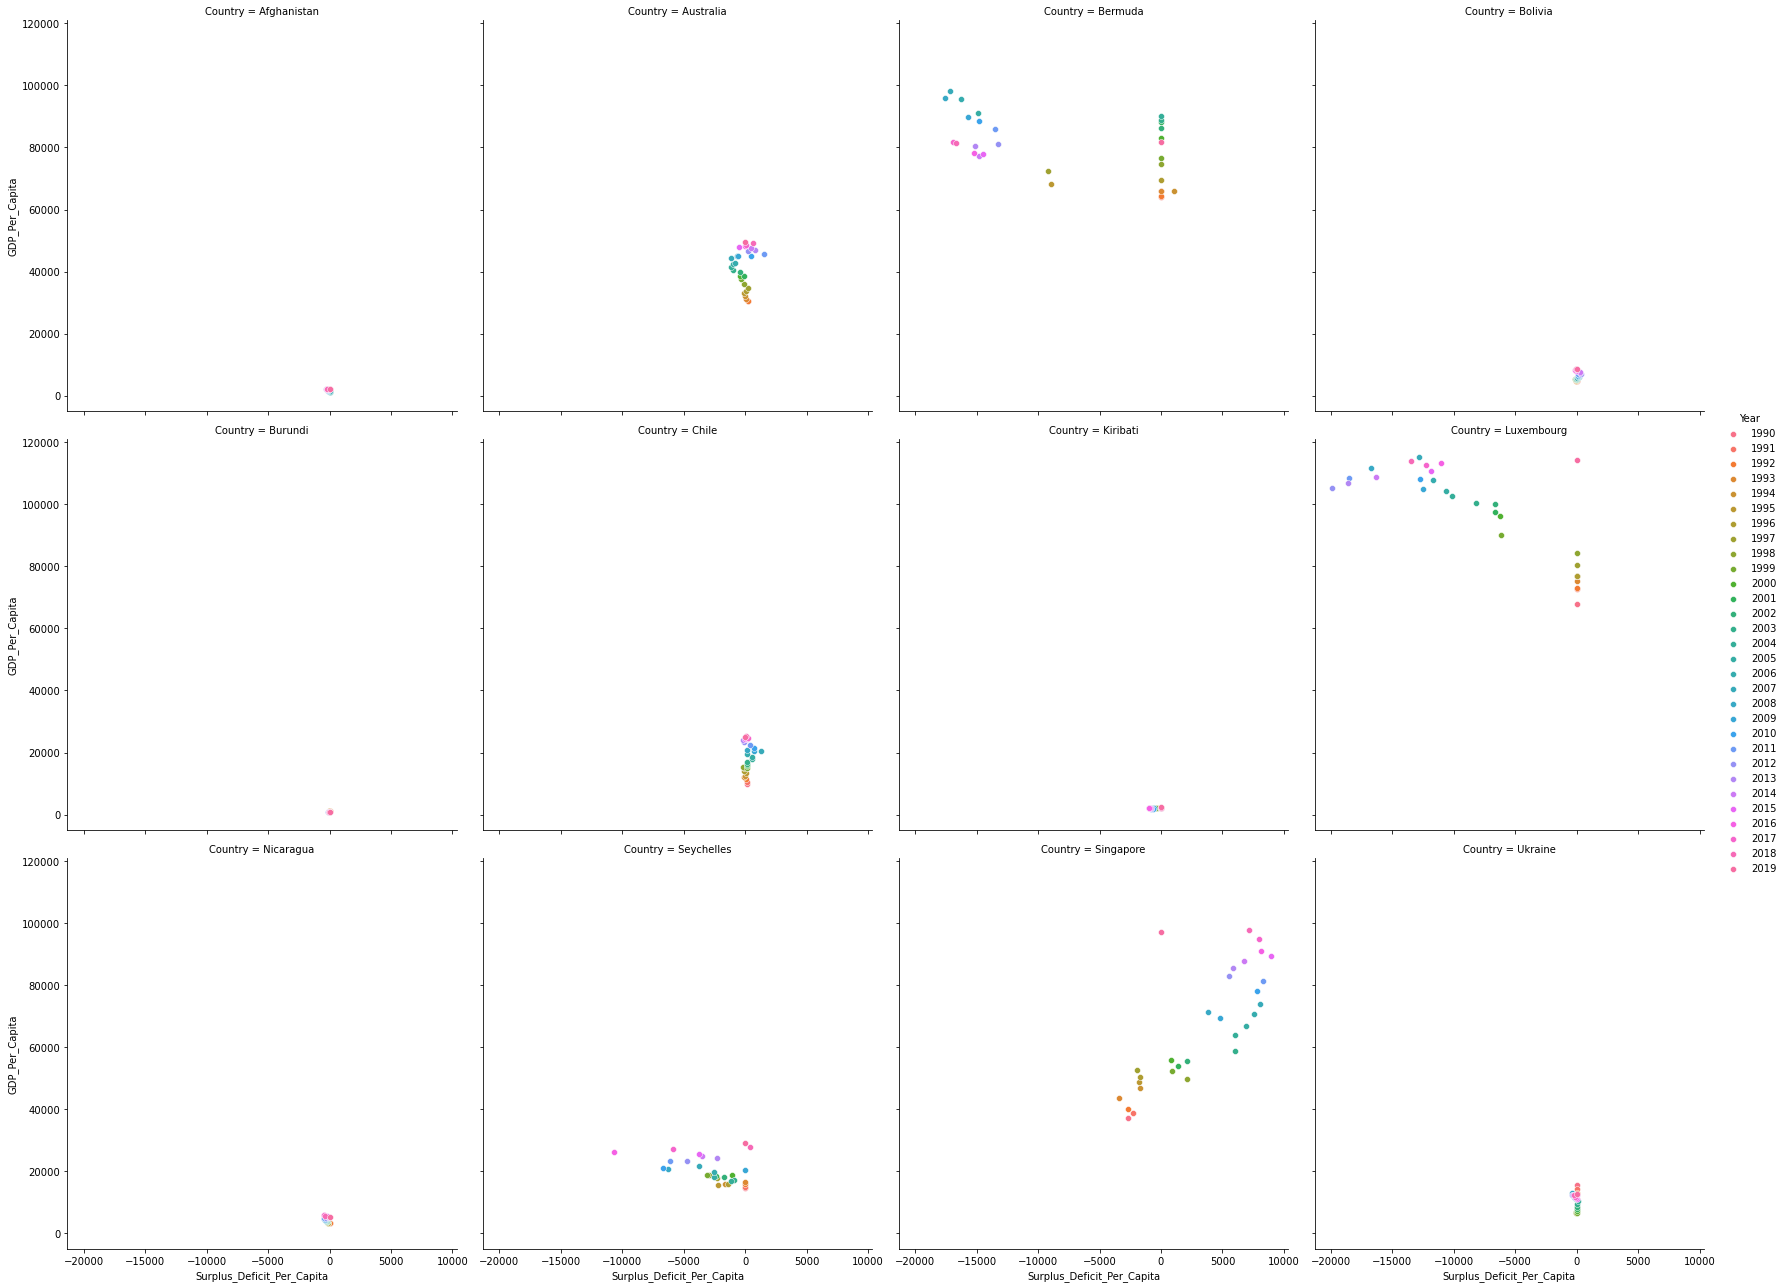

In [57]:
#g7 = sns.FacetGrid(
#    filtered_gdp_cont_pop_trade,
#    col='Country',
#    col_wrap=4,
#    hue='Year'
#)
#g7.map(sns.scatterplot, 'Surplus_Deficit_Per_Capita', 'GDP_Per_Capita')
#g7.add_legend()


countries_plot(
    dataset=filtered_gdp_cont_pop_trade,
    country_list=minmax_gdp2019_countries, #even though it's already fildered by this (function has to have this argument)
    nplots_row = 4,
    plot_x = 'Surplus_Deficit_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    hue_var = 'Year'
    )

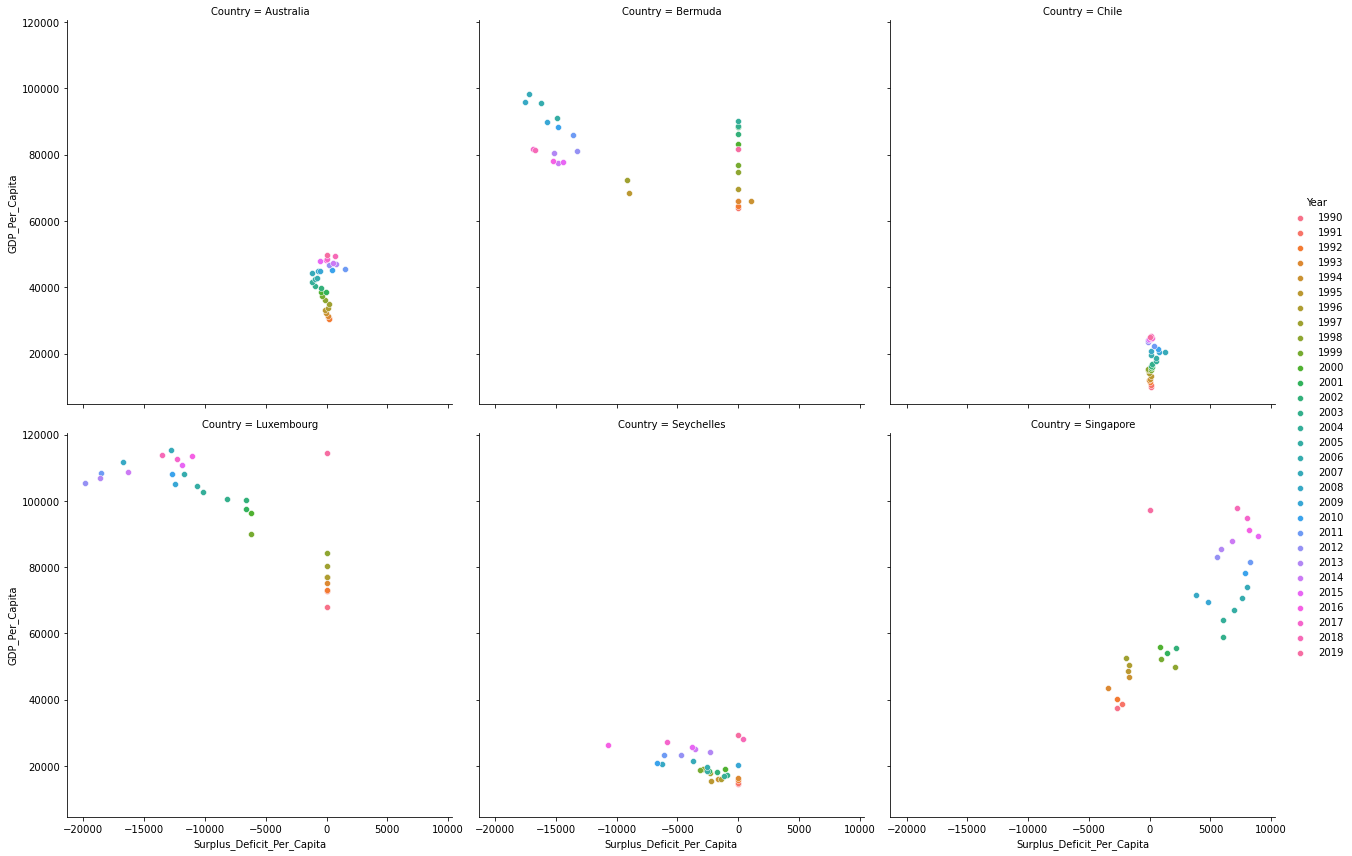

In [58]:
#g7max = sns.FacetGrid(
#    filtered_gdp_cont_pop_trade.loc[filtered_gdp_cont_pop_trade['Country'].isin(max_gdp2019_countries)],
#    col='Country',
#    col_wrap=3,
#    hue='Year',
#    height=6
#)
#g7max.map(sns.scatterplot, 'Surplus_Deficit_Per_Capita', 'GDP_Per_Capita')
#g7max.add_legend()

countries_plot(
    dataset=filtered_gdp_cont_pop_trade,
    country_list=max_gdp2019_countries,
    nplots_row = 3,
    plot_x = 'Surplus_Deficit_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    hue_var = 'Year'
    )

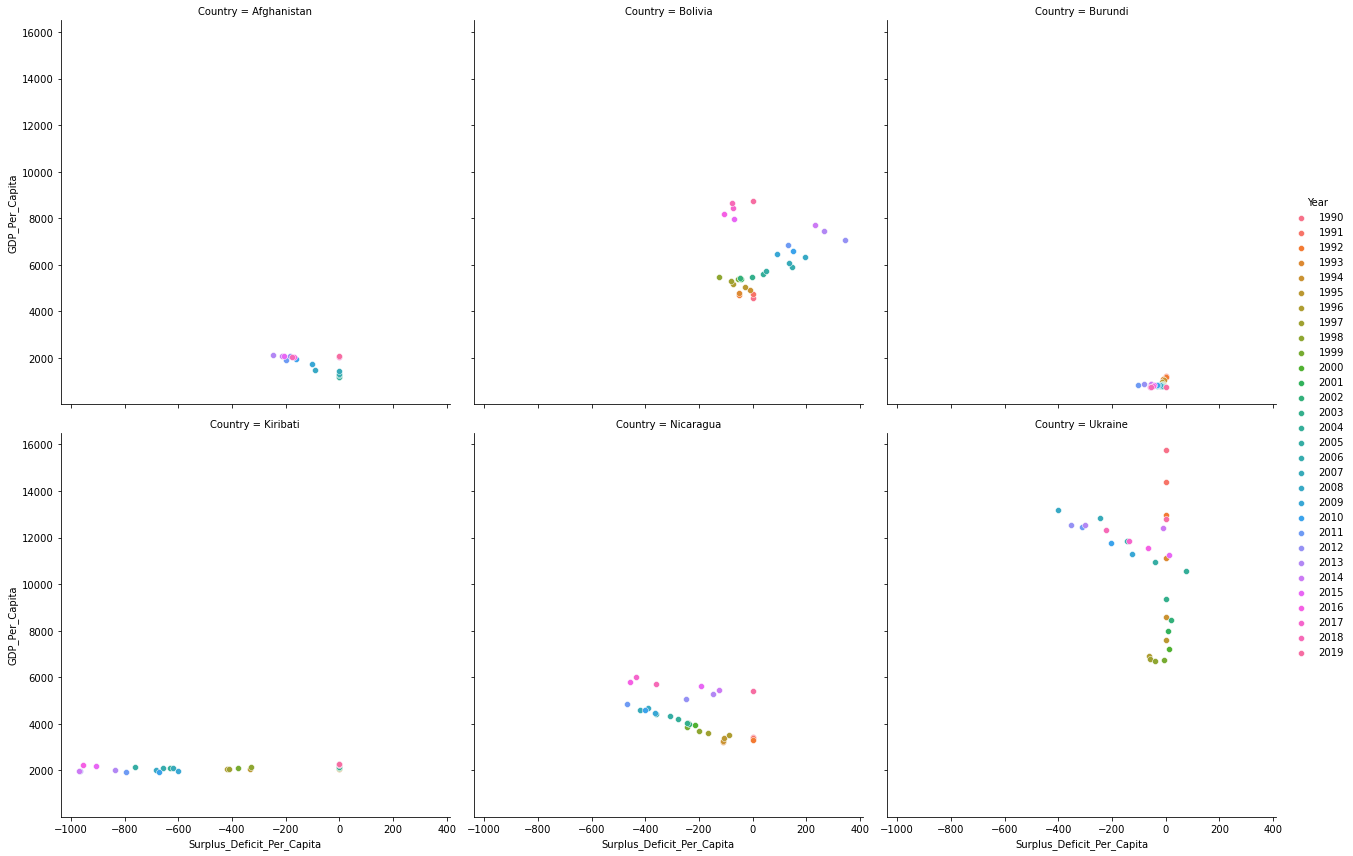

In [59]:
#g7min = sns.FacetGrid(
#    filtered_gdp_cont_pop_trade.loc[filtered_gdp_cont_pop_trade['Country'].isin(min_gdp2019_countries)],
#    col='Country',
#    col_wrap=3,
#    hue='Year',
#    height=6
#)
#g7min.map(sns.scatterplot, 'Surplus_Deficit_Per_Capita', 'GDP_Per_Capita')
#g7min.add_legend()

countries_plot(
    dataset=filtered_gdp_cont_pop_trade,
    country_list=min_gdp2019_countries,
    nplots_row = 3,
    plot_x = 'Surplus_Deficit_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    hue_var = 'Year'
    )

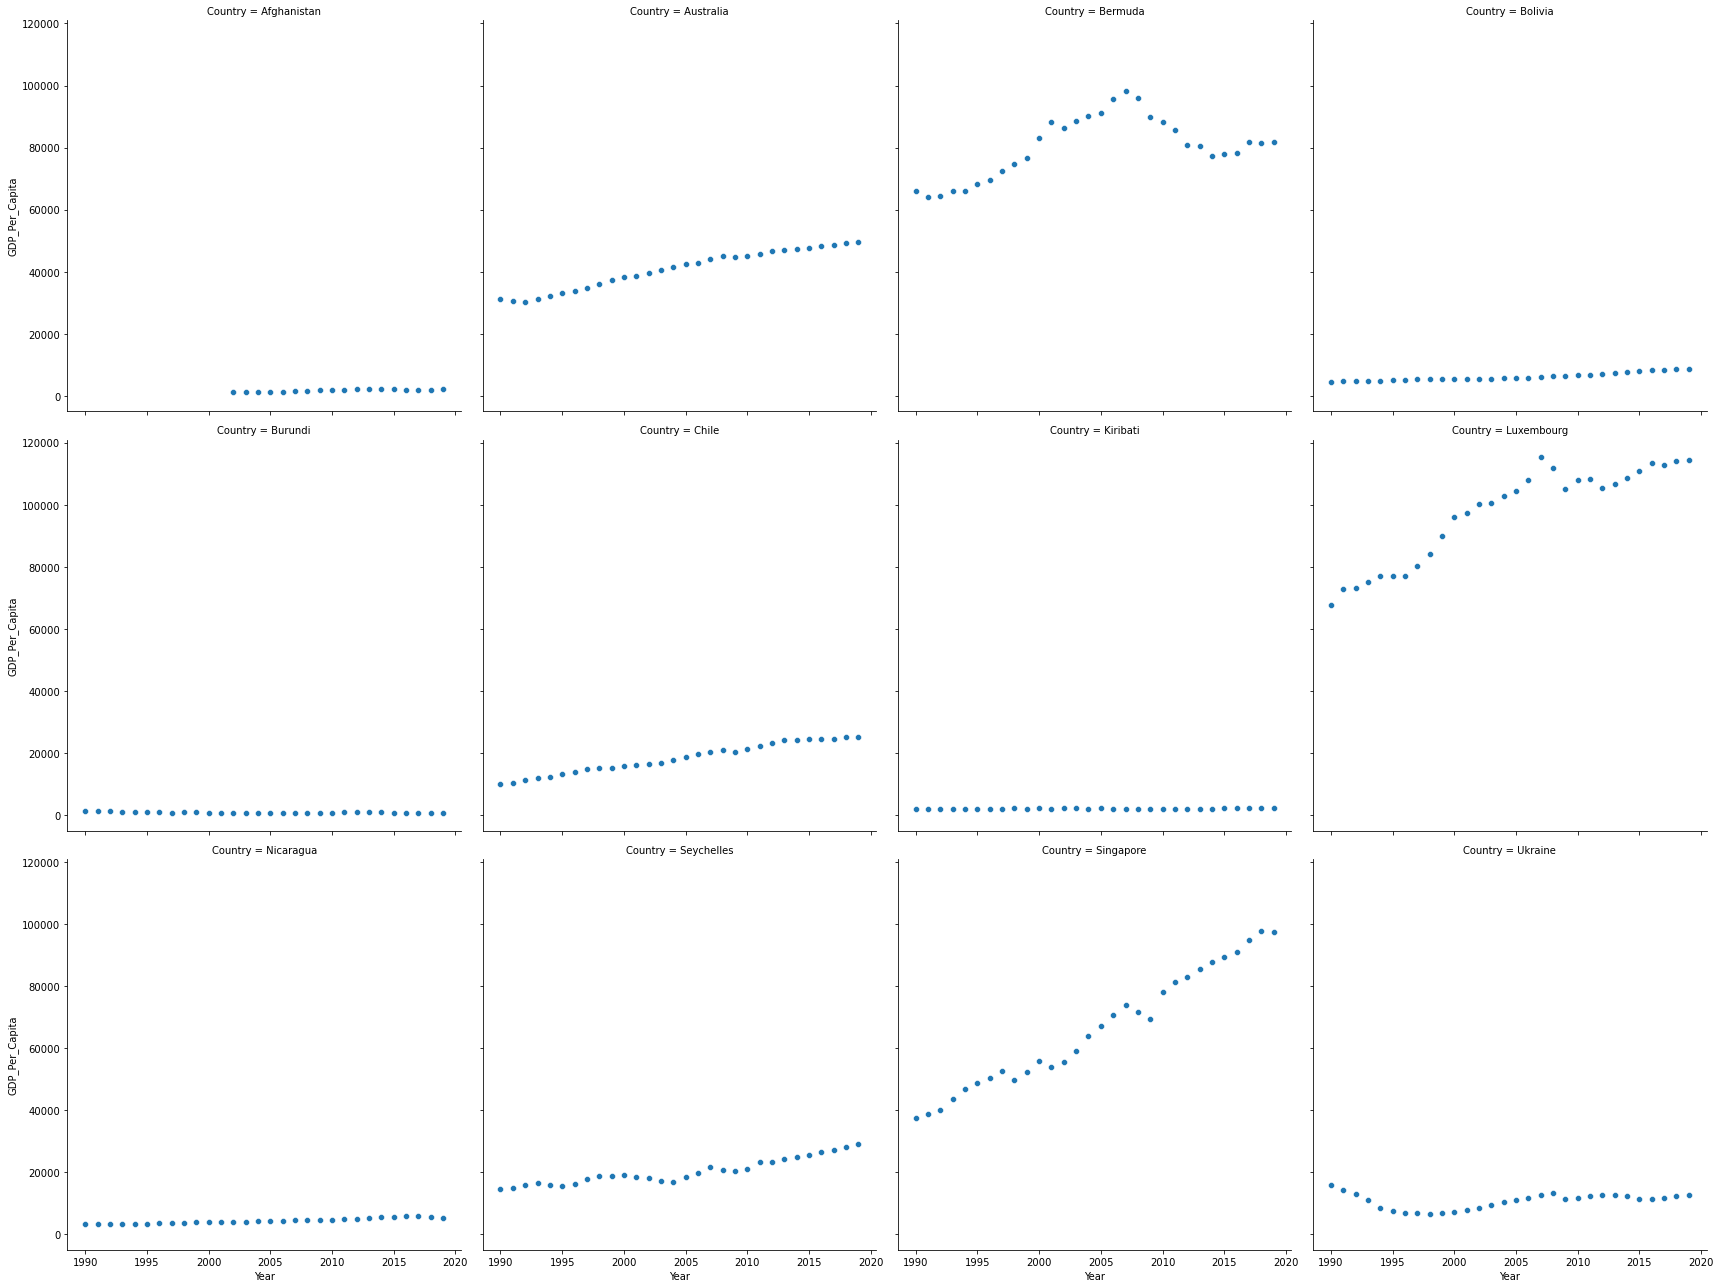

In [60]:
#g8 = sns.FacetGrid(
#    filtered_gdp_cont_pop_trade,
#    col='Country',
#    col_wrap=4
#)
#g8.map(sns.scatterplot, 'Year', 'GDP_Per_Capita')
#g8.add_legend()

countries_plot(
    dataset=filtered_gdp_cont_pop_trade,
    country_list=minmax_gdp2019_countries,
    nplots_row = 4,
    plot_x = 'Year',
    plot_y = 'GDP_Per_Capita'
    )

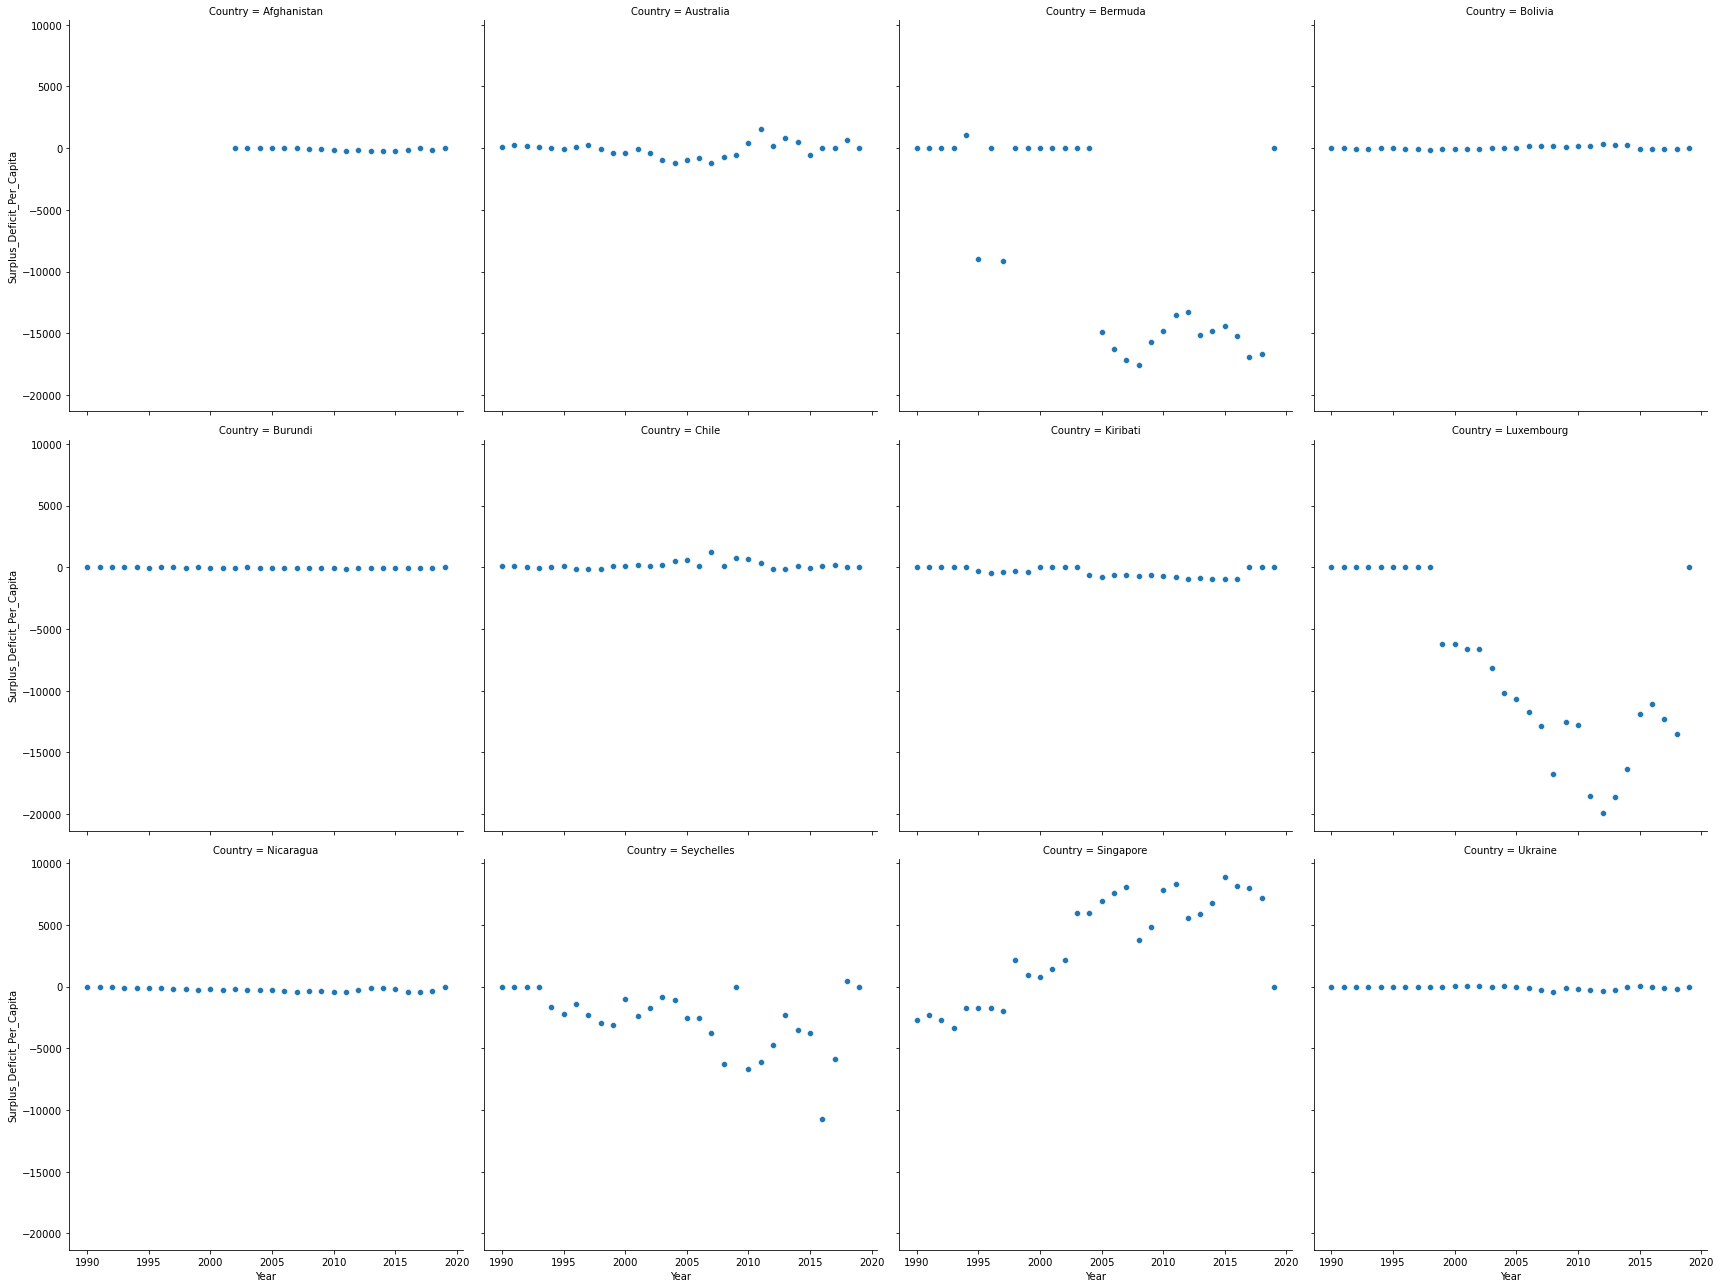

In [61]:
#g9 = sns.FacetGrid(
#    filtered_gdp_cont_pop_trade,
#    col='Country',
#    col_wrap=4
#)
#g9.map(sns.scatterplot, 'Year', 'Surplus_Deficit_Per_Capita')
#g9.add_legend()

countries_plot(
    dataset=filtered_gdp_cont_pop_trade,
    country_list=minmax_gdp2019_countries,
    nplots_row = 4,
    plot_x = 'Year',
    plot_y = 'Surplus_Deficit_Per_Capita'
    )

In [79]:
def countries_interactive (dataset, country_list, plot_x, plot_y, color_var=None, symbol_var=None) :
    """ Function to Plot 2 variables on same interactive plot for countries """
    fig = px.line(
        dataset
            .loc[dataset['Country'].isin(country_list)],
        x=plot_x,
        y=plot_y,
        color=color_var,
        symbol=symbol_var
    )
    fig.show()

In [82]:
countries_interactive (
    dataset = filtered_gdp_cont_pop_trade,
    country_list = max_gdp2019_countries,
    plot_x = 'Year',
    plot_y = 'GDP_Per_Capita',
    color_var = 'Country'#,
    #symbol_var = 'Country',
)

In [83]:
countries_interactive (
    dataset = filtered_gdp_cont_pop_trade,
    country_list = min_gdp2019_countries,
    plot_x = 'Year',
    plot_y = 'GDP_Per_Capita',
    color_var = 'Country'#,
    #symbol_var = 'Country',
)

In [84]:
countries_interactive (
    dataset = filtered_gdp_cont_pop_trade,
    country_list = max_gdp2019_countries,
    plot_x = 'Year',
    plot_y = 'Surplus_Deficit_Per_Capita',
    color_var = 'Country'#,
    #symbol_var = 'Country',
)

In [85]:
countries_interactive (
    dataset = filtered_gdp_cont_pop_trade,
    country_list = min_gdp2019_countries,
    plot_x = 'Year',
    plot_y = 'Surplus_Deficit_Per_Capita',
    color_var = 'Country'#,
    #symbol_var = 'Country',
)

Looking at the two graphs above: it is interesting how for the top GDP countries, the surplus (or lack thereoff) oscilates in larger values - up to 20 Million in USD. For poorest GDP countries it is contained within a Million

In [66]:
fig5 = px.scatter(filtered_gdp_cont_pop_trade.loc[filtered_gdp_cont_pop_trade['Country'] == 'Luxembourg'], x='Surplus_Deficit_Per_Capita', y='GDP_Per_Capita', color='Year')
fig5.show()

After all this work, made the seaborn plot as a function!! Lots of commented code as a result.

In [110]:
def countries_inter_scatter (dataset, country_list, plot_x, plot_y, size_var=None, color_var=None, symbol_var=None) :
    """ Function to Plot 2 variables on same interactive scatterplot for countries """
    fig = px.scatter(
        dataset
            .loc[dataset['Country'].isin(country_list)],
        x=plot_x,
        y=plot_y,
        marginal_x='box',
        marginal_y='box',
        size=size_var,
        color=color_var,
        symbol=symbol_var
    )
    fig.show()

In [111]:
countries_inter_scatter (
    dataset = filtered_gdp_cont_pop_trade,
    country_list = max_gdp2019_countries,
    plot_x = 'Surplus_Deficit_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    size_var = 'Population',
    color_var = 'Country',
    symbol_var = 'Country'
)

In [112]:
countries_inter_scatter (
    dataset = filtered_gdp_cont_pop_trade,
    country_list = min_gdp2019_countries,
    plot_x = 'Surplus_Deficit_Per_Capita',
    plot_y = 'GDP_Per_Capita',
    size_var = 'Population',
    color_var = 'Country',
    symbol_var = 'Country'
)

In [69]:
filtered_gdp_cont_pop_trade.head()

,Country,Year,GDP_Per_Capita,Continent,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
0,Afghanistan,2019,2065.036398,Asia,38041754.0,0.000000e+00,0.000000e+00,0.00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
1,Afghanistan,2018,2033.779002,Asia,37171921.0,8.845045e+08,7.406590e+09,9263097.24,0.0,-6.512823e+09,23.794963,199.252288,0.249196,0.0,-175.208129
2,Afghanistan,2017,2058.383832,Asia,36296113.0,0.000000e+00,0.000000e+00,0.00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000
3,Afghanistan,2016,2057.062164,Asia,35383032.0,5.964553e+08,6.534140e+09,0.00,0.0,-5.937685e+09,16.857101,184.668753,0.000000,0.0,-167.811653
4,Afghanistan,2015,2068.265904,Asia,34413603.0,5.714050e+08,7.722865e+09,0.00,0.0,-7.151460e+09,16.604044,224.413150,0.000000,0.0,-207.809106


In [116]:
filtered_gdp_cont_pop_trade.describe()

,Year,GDP_Per_Capita,Population,Export,Import,Re-Export,Re-Import,Surplus_Deficit,Export_Per_Capita,Import_Per_Capita,Re-Export_Per_Capita,Re-Import_Per_Capita,Surplus_Deficit_Per_Capita
count,348.000000,348.000000,3.480000e+02,3.480000e+02,3.480000e+02,3.480000e+02,3.480000e+02,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2004.810345,30060.760467,1.120140e+07,3.679545e+10,3.629105e+10,8.275088e+07,3.848697e+07,5.486654e+08,6561.484216,8024.854674,96.199765,8.713708,-1375.884401
std,8.626326,33752.570942,1.401863e+07,8.115372e+10,7.489760e+10,4.164707e+08,1.576376e+08,9.328661e+09,15131.543917,15233.170964,374.772915,40.893264,4630.392567
min,1990.000000,751.663957,6.163400e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.495572e+10,0.000000,0.000000,0.000000,0.000000,-19887.070718
25%,1997.000000,3823.498450,1.137495e+05,7.062154e+06,1.183614e+08,0.000000e+00,0.000000e+00,-1.230443e+09,11.699660,54.831949,0.000000,0.000000,-552.956923
50%,2005.000000,14521.840453,5.814201e+06,7.625802e+08,1.867904e+09,0.000000e+00,0.000000e+00,-9.961054e+07,351.106024,836.142936,0.000000,0.000000,-42.562828
75%,2012.000000,48666.779488,1.698608e+07,3.332605e+10,2.997928e+10,0.000000e+00,0.000000e+00,0.000000e+00,3589.134966,7832.627066,0.000000,0.000000,0.000000
max,2019.000000,115256.016699,5.146310e+07,4.199317e+11,3.880467e+11,3.454320e+09,1.057712e+09,4.981957e+10,79087.766671,71856.674977,3397.993572,426.317071,8908.837563


In [120]:
fig = px.scatter(filtered_gdp_cont_pop_trade, x="Surplus_Deficit_Per_Capita", y="GDP_Per_Capita", animation_frame="Year", animation_group="Country",
           size="Population", color="Continent", hover_name="Country", size_max=45, range_x=[-20000,9000], range_y=[750,116000])
fig.show()